<h1><center>Text classification with Pytorch</center></h1>
<h3><center>Authors: Aymane BERRADI, Taoufik AGHRIS</center></h3>
<h5><center>03/04/2021</center></h5>

# Table of Contents
* [Import Libraries](#Import-Libraries)
* [Data processing of a text dataset](#Data-processing-of-a-text-dataset)
* [Useful functions](#Useful-functions)
* [Averaging Models](#Averaging-Models)
    * [A simple averaging model](#A-simple-averaging-model)
    * [Pretrained averaging model](#Pretrained-averaging-model)
    * [Questions](#Questions)
        * [Question 1](#Question-1)
        * [Question 2](#Question-2)
            * [Number of documents](#1.-Number-of-documents)
                * [Hypothesis](#1.1-Hypothesis)
                * [Experiments](#1.2-Experiments)
                * [Results-and-Analysis](#1.3-Results-and-Analysis)
                * [Conclusion](#1.4-Conclusion)
            * [Minimum-frequency](#2.-Minimum-frequency)
                * [Hypothesis](#2.1-Hypothesis)
                * [Experiments](#2.2-Experiments)
                * [Results-and-Analysis](#2.3-Results-and-Analysis)
                * [Conclusion](#2.4-Conclusion)
* [Deep Learning Algorithms](#Deep-Learning-Algorithms)      
    * [LSTM Model](#LSTM-Model)
    * [CNN Model](#CNN-Model)
    * [Questions](#Questions:)
        * [Question 1](#Question-1:)
        * [Question 2](#Question-2:)
            * [Hypotheses](#Hypotheses)
            * [Number of documents](#Number-of-documents)
                * [Experiments: LSTM](#1.1-Experiments:-LSTM)
                * [Results-and-Analysis: LSTM](#1.2-Results-and-Analysis:-LSTM)
                * [Experiments: CNN](#1.3-Experiments:-CNN)
                * [Results-and-Analysis: CNN](#1.4-Results-and-Analysis:-CNN)
            * [Minimum-frequency](#Minimum-frequency)
                * [Experiments: LSTM](#2.1-Experiments:-LSTM)
                * [Results-and-Analysis: LSTM](#2.2-Results-and-Analysis:-LSTM)
                * [Experiments: CNN](#2.3-Experiments:-CNN)
                * [Results-and-Analysis: CNN](#2.4-Results-and-Analysis:-CNN)
                * [Conclusion](#Conclusion)

The goal of this TP is double: an introduction to using Pytorch for treating textual data, and implementing neural classification models that we can apply to IMDB data - and then compare to models implemented in the previous TPs. 

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import nltk
import operator
import torch.optim as optim
from tqdm import tqdm
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda")
torch.manual_seed(2021)
import time
import random
import os
import pandas as pd
from torch.nn import functional as Func
import numpy as np
from nltk import word_tokenize
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from glob import glob

# Data processing of a text dataset

Now, we would like to apply what we saw to our case, and **create a specific class** ```TextClassificationDataset``` **inheriting** ```Dataset``` that will:
- Create a vocabulary from the data (use what we saw in the previous TP)
- Preprocess the data using this vocabulary, adding whatever we need for our pytorch model
- Have a ```__getitem__``` method that allows us to use the class with a ```Dataloader``` to easily build batches.

First, we get the filenames and the corresponding categories: 

In [14]:
filenames_neg = sorted(glob(os.path.join('.', 'data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(os.path.join('.', 'data', 'imdb1', 'pos', '*.txt')))
filenames = filenames_neg + filenames_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
categories = np.ones(len(filenames), dtype=np.int)
categories[:len(filenames_neg)] = 0.

print("%d documents" % len(filenames))

25000 documents


We will need to create a ```TextClassificationDataset``` and a ```Dataloader``` for the training data, the validation data, and the testing data. We need to implement a function that will help us split the data in three, according to proportions we give in input.

In [15]:
# Create a function allowing you to simply shuffle then split the filenames and categories into the desired
# proportions for a training, validation and testing set. 
def get_splits(x, y, splits, portion=0):
    """
    The idea is to use an index list as reference:
    Indexes = [0 1 2 3 4 5 6 7 8 9]
    To shuffle it randomly:
    Indexes = [7 1 5 0 2 9 8 6 4 3]
    We need 'splits' to contain 2 values. Assuming those are = (0.8, 0.1), we'll have:
    Train_indexes = [7 1 5 0 2 9 8 6]
    Valid_indexes = [4]
    Test_indexes = [3]
    """
    # Create an index list and shuffle it - use the function random.shuffle
    torch.manual_seed(0)

    indexes = [i for i in range(len(x))]
    random.shuffle(indexes)
    if portion>0:
        indexes = indexes[0:int(portion*len(indexes))]
    # Find the two indexes we'll use to cut the lists from the splits
    Train_indexes = indexes[0: int(splits[0]*len(indexes))]
    Valid_indexes = indexes[int(splits[0]*len(indexes)): int((splits[0] + splits[1])*len(indexes))]
    Test_indexes = indexes[int((splits[0] + splits[1])*len(indexes)):]
    # Do the cutting (careful: you can't use a list as index for a list - this only works with tensors)
    train_x, train_y = [x[i] for i in Train_indexes], [y[i] for i in Train_indexes]# A compléter
    valid_x, valid_y = [x[i] for i in Valid_indexes], [y[i] for i in Valid_indexes]# A compléter
    test_x, test_y = [x[i] for i in Test_indexes], [y[i] for i in Test_indexes]# A compléter
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [16]:
# Choose the training, validation, testing splits
splits = (0.8, 0.1)
(train_f, train_c), (valid_f, valid_c), (test_f, test_c) = get_splits(filenames, categories, splits)

Let's do a quick check to see if the **get_splits** function works as expected.

In [17]:
total = len(filenames)
print((len(train_f)/total, len(valid_f)/total, len(test_f)/total))

(0.8, 0.1, 0.1)


We can now implement our ```TextClassificationDataset``` class, that we will build from:
- A list of path to the IMDB files in the training set: ```path_to_file```
- A list of the corresponding categories: ```categories```
We will add three optional arguments:
- First, a way to input a vocabulary (so that we can re-use the training vocabulary on the validation and training ```TextClassificationDataset```). By default, the value of the argument is ```None```.
- In order to work with batches, we will need to have sequences of the same size. That can be done via **padding** but we will still need to limit the size of documents (to avoid having batches of huge sequences that are mostly empty because of one very long documents) to a ```max_length```. Let's put it to 100 by default.
- Lastly, a ```min_freq``` that indicates how many times a word must appear to be taken in the vocabulary. 

The idea behind **padding** is to transform a list of pytorch tensors (of maybe different length) into a two dimensional tensor - which we can see as a batch. The size of the first dimension is the one of the longest tensor - and other are **padded** with a chosen symbol: here, we choose 0. 

In [18]:
tensor_1 = torch.LongTensor([1, 4, 5])
tensor_2 = torch.LongTensor([2])
tensor_3 = torch.LongTensor([6, 7])

In [19]:
tensor_padded = pad_sequence([tensor_1, tensor_2, tensor_3], batch_first=True, padding_value = 0)
print(tensor_padded)

tensor([[1, 4, 5],
        [2, 0, 0],
        [6, 7, 0]])


In [20]:
class TextClassificationDataset(Dataset):
    def __init__(self, paths_to_files, categories, vocab = None, max_length = 100, min_freq = 5):
        # Read all files and put the data in a list of strings
        self.data = [open(f, encoding="utf8").read() for f in paths_to_files if len(f)>0]# A compléter
        
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, min_freq)
        
        # We then need to tokenize the data .. 
        tokenized_data = [nltk.word_tokenize(sentence) for sentence in self.data]
        indexed_data = []
        
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        for sentence in tokenized_data:
            indexed_data.append([self.word2idx.get(word, len(self.word2idx)-1) for word in sentence])
            
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(index) for index in indexed_data]
        # And the categories into a FloatTensor
        tensor_y = torch.FloatTensor(categories)
        # To finally cut it when it's above the maximum length
        cut_tensor_data = [tensor[:max_length] for tensor in tensor_data]
        
        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension 
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value = 0)
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, count_threshold):
        """
        Same as in the previous TP: we want to output word_index, a dictionary containing words 
        and their corresponding indexes as {word : indexes} 
        But we also want the reverse, which is a dictionary {indexes: word}
        Don't forget to add a UNK token that we need when encountering unknown words
        We also choose '0' to represent the padding index, so begin the vocabulary index at 1 ! 
        """
        # Count the frequence of each word
        word_counts = {}
        for sentence in tqdm(corpus):
            sentence = nltk.word_tokenize(sentence)
            for word in sentence:
                if word in word_counts.keys():
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
        
        # Sort the dictionnary from high to low frequecies
        sorted_dic = dict(sorted(word_counts.items(), key=operator.itemgetter(1), reverse = True))
        
        # Keep only frenquecies that are greather than count_threshold
        if count_threshold > 0:
            filtered_word_counts = dict(filter(lambda elem: elem[1] > count_threshold ,sorted_dic.items()))
        elif count_threshold==0:
            filtered_word_counts = sorted_dic
        
        # Constructing the word_index dictionnary with keys as the tokens and values as the indexes
        word_index = {}
        word_index['PAD'] = 0
        for i, key in enumerate(filtered_word_counts.keys()):
            word_index[key] = i+1
        word_index['UNK'] = len(word_index) + 1
        
        # Reverse the keys and values of the word_index dictionnary
        idx_word = dict((v,k) for k,v in zip(word_index.keys(), word_index.values()))
        return word_index, idx_word
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.word2idx, self.idx2word

In [21]:
training_dataset = TextClassificationDataset(train_f, train_c)
training_word2idx, training_idx2word = training_dataset.get_vocab()

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:46<00:00, 431.51it/s]


In [22]:
valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))

In [23]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [24]:
print(training_dataset[0])

(tensor([   11,    12,     9,    10,    11,    12,     9,    10, 28248,    42,
        28248,    13,   520,   748,  1221,     2,     1, 14309,   223,   277,
           22,     1, 11525, 19120,   802,     7, 25613, 28248,    51,   114,
            7,     1,   457, 14310,     6,   795,    13,     5,   105, 28248,
           11,    12,     9,    10,    11,    12,     9,    10,  2159,  2811,
            8,  1479,    21,     1,  9585,  1889,     6,    18,  9347, 21785,
          515,     3,  2205,     5,  8007,     6, 10593,    53,  2629,     2,
           73, 23535, 13732,     1, 16346,    53,  3810,     6,     1,   405,
        10316,   212,     7,   180,   564,    13,    51,   114,     3,   136,
          435,   578,     2,  2811,    55,   463,  1436,   164,     7,  2458]), tensor(1.))


In [25]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([200, 100])
torch.Size([200])


# Useful functions

In [26]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader, GPU=False):
    model.train()
    losses = []
    accs = []
    total_epoch_loss = 0
    total_epoch_acc = 0
    for i, (x, y) in enumerate(tqdm(dataloader)):
        if GPU:
            x = x.to(device)
            y = y.to(device)
        opt.zero_grad()
        # (1) Forward
        pred = model(x)# A compléter
        # (2) Compute the loss 
        loss = criterion(pred, y)# A compléter
        # (3) Compute gradients with the criterion
        loss.backward()
        # (4) Update weights with the optimizer
        opt.step()      
        losses.append(loss.item())
        pred = torch.sigmoid(pred)
        pred = torch.round(pred)
        num_corrects = (pred==y).float().sum()# A compléter
        acc = 100.0 * num_corrects/len(y)
        accs.append(acc)
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
       # if (i%20 == 0):
         #   print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
            
    return losses, total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [27]:
# Same for the evaluation ! We don't need the optimizer here. 
def eval_model(model, criterion, evalloader, GPU=False):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            if GPU:
                x = x.to(device)
                y = y.to(device)
            pred = model(x)# A compléter
            loss = criterion(pred, y)# A compléter
            pred = torch.sigmoid(pred)
            pred = torch.round(pred)
            num_corrects = (pred==y).float().sum()# A compléter
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [28]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary. 
def experiment(model, opt, criterion, tr_dataloader=training_dataloader,
               val_dataloader=valid_dataloader, num_epochs = 5, early_stopping = True, GPU=False):
    train_losses = []
    train_epoch_losses = []
    val_epoch_losses = []
    train_epoch_accs = []
    val_epoch_accs = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
       # print("Epoch " + str(e+1) + ":")
        result = train_epoch(model, opt, criterion, tr_dataloader, GPU=GPU)
        train_losses += result[0]
    
        train_loss = result[1]
        train_epoch_losses.append(train_loss)
        
        train_acc = result[2]
        train_epoch_accs.append(train_acc)
        
        valid_loss, valid_acc = eval_model(model, criterion, val_dataloader, GPU=GPU)
        val_epoch_losses.append(valid_loss)
        val_epoch_accs.append(valid_acc)
        print("Epoch " + str(e+1) + " : Training loss = " + str(train_loss) + "; Training acc = " + str(train_acc))
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    #test_loss, test_acc = eval_model(model, criterion, test_dataloader, GPU=GPU)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    return train_losses, train_epoch_losses, val_epoch_losses, train_epoch_accs, val_epoch_accs

To plot results we use the following functions

In [ ]:
def plot_results(train, valid, model_version):
    sns.set(rc={'figure.figsize':(15, 6)})
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
    epochs = [j for j in range(5)]
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("accuracy")
    for i in range(len(portions)):
        sns.lineplot(x=epochs, y=train[i], label='portion:'+str(df.portion[i]), ax=ax1)
        sns.lineplot(x=epochs, y=valid[i], label='portion:'+str(df.portion[i]), ax=ax2)
    fig.suptitle("Variation of accuracies for different portions of documents for : "+str(model_version))

In [ ]:
def plot_results_1(train, valid, model_version):
    sns.set(rc={'figure.figsize':(15, 6)})
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
    epochs = [j for j in range(5)]
   
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("accuracy")
    for i in range(len(min_frequences)):
        sns.lineplot(x=epochs, y=train[i], label='min frequence:'+str(df["min frequence"][i]), ax=ax1)
        sns.lineplot(x=epochs, y=valid[i], label='min frequence:'+str(df["min frequence"][i]), ax=ax2)
    fig.suptitle("Variation of accuracies for different minimum frequencies of documents for : "+str(model_version))

In [ ]:
def plot_results_2(model_resuts, model_name, test_name, test_elemnts): 
    sns.set(rc={'figure.figsize':(15, 10)})
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, sharey=True, sharex=True)
    for i in range(len(test_elemnts)):
        sns.lineplot(x=[i for i in range(5)] ,y=model_resuts.acc_tr_no_pt_dic[i], label=str(test_name)+':'+str(model_resuts[str(test_name)][i]), ax=ax1)
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Training accuracy of the '+str(model_name)+' model without pretrained embedding', fontsize=10)
        sns.lineplot(x=[i for i in range(5)] ,y=model_resuts.acc_val_no_pt_dic[i], label=str(test_name)+':'+str(model_resuts[str(test_name)][i]), ax=ax2)
        ax2.set_title('Validation accuracy of the '+str(model_name)+' model without pretrained embedding', fontsize=10)

        sns.lineplot(x=[i for i in range(5)] ,y=model_resuts.acc_tr_pt_no_fn_dic[i], label=str(test_name)+':'+str(model_resuts[str(test_name)][i]), ax=ax3)
        ax3.set_ylabel('Accuracy')
        ax3.set_title('Training accuracy of the '+str(model_name)+' model with pretrained embedding', fontsize=10)
        sns.lineplot(x=[i for i in range(5)] ,y=model_resuts.acc_val_pt_no_fn_dic[i], label=str(test_name)+':'+str(model_resuts[str(test_name)][i]), ax=ax4)
        ax4.set_ylabel('Accuracy')
        ax4.set_title('Validation accuracy of the '+str(model_name)+' model with pretrained embedding', fontsize=10)

        sns.lineplot(x=[i for i in range(5)] ,y=model_resuts.acc_tr_pt_fn_dic[i], label=str(test_name)+':'+str(model_resuts[str(test_name)][i]), ax=ax5)
        ax5.set_xlabel('Epoch')
        ax5.set_ylabel('Accuracy')
        ax5.set_title('Training accuracy of the '+str(model_name)+' model with pretrained embedding and fine tuning', fontsize=10)
        sns.lineplot(x=[i for i in range(5)] ,y=model_resuts.acc_val_pt_fn_dic[i], label=str(test_name)+':'+str(model_resuts[str(test_name)][i]), ax=ax6)
        ax6.set_xlabel('Epoch')
        ax6.set_title('Validation accuracy of the '+str(model_name)+' model with pretrained embedding and fine tuning', fontsize=10)
    plt.show

In [ ]:
def test_accuracy(model_results, title, tests_name):
    sns.set(rc={'figure.figsize':(10, 5)})
    fig, ax1 = plt.subplots(ncols=1, sharey=True)
    #sns.lineplot(data=df[[col for col in df.columns if 'test' in col]], ax = ax1)
    ax1.set_xlabel(str(title))
    ax1.set_ylabel("accuracy")
    sns.lineplot(x=model_results[tests_name], y=model_results.acc_test_pt_fn_dic, label="pre-training with fine-tuning",ax=ax1)
    sns.lineplot(x=model_results[tests_name], y=model_results.acc_test_no_pt_dic, label="no-pretrained_model",ax=ax1)
    sns.lineplot(x=model_results[tests_name], y=model_results.acc_test_pt_no_fn_dic, label="pre-training without fine-tuning ",ax=ax1)
    ax1.legend()
    ax1.set_title('Variation of accuracies on testing set')

# Averaging Models

## A simple averaging model

Now, we will implement in Pytorch what we did in the previous TP: a simple averaging model. For each model we will implement, we need to create a class which inherits from ```nn.Module``` and redifine the ```__init__``` method as well as the ```forward``` method.

In [29]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class AveragingModel(nn.Module):    
    def __init__(self, embedding_dim, vocabulary_size):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim)
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(embedding_dim, 1)
        self.dim = embedding_dim
        # No need for sigmoid, it will be into the criterion ! 
        
    def forward(self, inputs):
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs)
        x = torch.mean(x.float(), 1)
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = self.linear(x).squeeze()
        return o

In [30]:
import torch.optim as optim

In [31]:
model = AveragingModel(300, len(training_word2idx))
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a binary cross entropy loss based on logits - meaning that the sigmoid is integrated into the criterion
criterion = nn.BCEWithLogitsLoss()

## Pretrained averaging model

### With Glove embeddings: 

Now, we would like to integrate pre-trained word embeddings into our model ! Let's use again the functions that we used in the previous TP:

In [32]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

In [33]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

In [34]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [35]:
print(GloveEmbeddings.shape)
# We should check that the "padding" vector is at zero
print(GloveEmbeddings[0])

(28250, 300)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Here, implement a ```PretrainedAveragingModel``` very similar to the previous model, using the ```nn.Embedding``` method ```from_pretrained()``` to initialize the embeddings from a numpy array. Use the ```requires_grad_``` method to specify if the model must fine-tune the embeddings or not ! 

In [ ]:
class PretrainedAveragingModel(nn.Module):
    """
    embedding_dim: the embedding dimension;
    embedding_weights: the weights of the embedding;
    non_trainable = False: to specify whether the embdedding need to be fine tuned
    """
    def __init__(self, embedding_dim, embedding_weights, non_trainable = False):
        super().__init__()
        self.embeddings = nn.Embedding.from_pretrained(torch.tensor(embedding_weights))
        self.embeddings.weight.requires_grad = non_trainable
        self.linear = nn.Linear(embedding_dim, 1)

        
    def forward(self, inputs):
        x = self.embeddings(inputs)
        x = torch.mean(x.float(), 1)
        o = self.linear(x).squeeze()
        return o

## Questions
- What are the results **with and without fine-tuning of embeddings imported from GloVe** ?
- Make hypothesis based on your intuition and the class on how
    - the number of documents (take only a portion of the 25.000 documents !)
    - the size of the vocabulary (change the minimum frequency of words to be taken in the vocabulary ! )
  will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning).
- Verify your hypothesis with experiments and analyze your results !

### Question 1

In this question, we are interested in comparing the 3 model versions, **No pre-training, pre-training without fine-tuning, pretraining with fine-tuning** with the full vocabulary **(25 000 documents)**.

In [ ]:
def initialize_model(Class, embedding_dim = None, vocabulary_size = None, embeddings = None, glove=False, non_trainable = False):
    if (glove == True):
        model = Class(embedding_dim, embeddings, non_trainable)
    else:
        model = Class(embedding_dim, vocabulary_size)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()
    return model, opt, criterion

In [ ]:
# No pre-training model
print("No pre-training model...")
model, opt, criterion = initialize_model(AveragingModel, 300, len(training_word2idx))
_, loss_tr_no_pt, loss_val_no_pt, acc_tr_no_pt, acc_val_no_pt = experiment(model, opt, criterion)

No pre-training model...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.50it/s]


Epoch 1 : Training loss = 0.6422420799732208; Training acc = 64.9
Epoch 1 : Validation loss = 0.5760722157359123; Validation acc = 73.08


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


Epoch 2 : Training loss = 0.48735071033239363; Training acc = 78.735
Epoch 2 : Validation loss = 0.4620737709105015; Validation acc = 78.36


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s]


Epoch 3 : Training loss = 0.367180298268795; Training acc = 85.33
Epoch 3 : Validation loss = 0.4139208613336086; Validation acc = 80.56


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.52it/s]


Epoch 4 : Training loss = 0.29199674636125567; Training acc = 89.195
Epoch 4 : Validation loss = 0.3919245372712612; Validation acc = 81.64


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s]


Epoch 5 : Training loss = 0.2391093322634697; Training acc = 91.7
Epoch 5 : Validation loss = 0.38565228417515757; Validation acc = 82.2
Epoch 5 : Test loss = 0.3890149503946304; Test acc = 82.48


In [ ]:
# pre-training without fine-tuning
print("Pre-training without fine-tuning...")
model, opt, criterion = initialize_model(PretrainedAveragingModel,embedding_dim = GloveEmbeddings.shape[1],
                                         embeddings = GloveEmbeddings, glove=True)
_, loss_tr_pt_no_fn, loss_val_pt_no_fn, acc_tr_pt_no_fn, acc_val_pt_no_fn = experiment(model, opt, criterion)

Pre-training without fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.27it/s]


Epoch 1 : Training loss = 0.6707075846195221; Training acc = 61.495
Epoch 1 : Validation loss = 0.6503444391489029; Validation acc = 66.64


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.80it/s]


Epoch 2 : Training loss = 0.6398863482475281; Training acc = 67.32
Epoch 2 : Validation loss = 0.6270689475536346; Validation acc = 68.68


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.34it/s]


Epoch 3 : Training loss = 0.619806370139122; Training acc = 68.845
Epoch 3 : Validation loss = 0.6094560012221336; Validation acc = 69.88


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.88it/s]


Epoch 4 : Training loss = 0.6046933341026306; Training acc = 70.29
Epoch 4 : Validation loss = 0.596586344242096; Validation acc = 70.28


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.89it/s]


Epoch 5 : Training loss = 0.5922334331274033; Training acc = 71.335
Epoch 5 : Validation loss = 0.58575344145298; Validation acc = 71.48
Epoch 5 : Test loss = 0.5873574516177178; Test acc = 72.12


In [ ]:
# pre-training with fine-tuning
print("Pre-training with fine-tuning...")
model, opt, criterion = initialize_model(PretrainedAveragingModel, embedding_dim = GloveEmbeddings.shape[1],
                                         embeddings = GloveEmbeddings, glove=True, non_trainable = True)
_, loss_tr_pt_fn, loss_val_pt_fn, acc_tr_pt_fn, acc_val_pt_fn = experiment(model, opt, criterion)

Pre-training with fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


Epoch 1 : Training loss = 0.6247322207689285; Training acc = 67.77
Epoch 1 : Validation loss = 0.532790898680687; Validation acc = 75.28


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


Epoch 2 : Training loss = 0.4330124047398567; Training acc = 82.265
Epoch 2 : Validation loss = 0.4196406327188015; Validation acc = 80.88


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch 3 : Training loss = 0.31715118065476416; Training acc = 87.895
Epoch 3 : Validation loss = 0.38624235764145853; Validation acc = 81.44


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


Epoch 4 : Training loss = 0.24810002252459526; Training acc = 91.265
Epoch 4 : Validation loss = 0.3803828291594982; Validation acc = 82.4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


Epoch 5 : Training loss = 0.19864130198955535; Training acc = 93.43
Epoch 5 : Validation loss = 0.38552523352205753; Validation acc = 82.4
Early stopping.
Epoch 5 : Test loss = 0.3837880942225456; Test acc = 82.92


In [ ]:
# We will save the results as Dataframe
import pandas as pd
df = pd.DataFrame(list(zip(loss_tr_no_pt, loss_val_no_pt, acc_tr_no_pt, acc_val_no_pt, 
                           loss_tr_pt_no_fn, loss_val_pt_no_fn, acc_tr_pt_no_fn, acc_val_pt_no_fn,
                           loss_tr_pt_fn, loss_val_pt_fn, acc_tr_pt_fn, acc_val_pt_fn)),
               columns =['loss_tr_no_pt', 'loss_val_no_pt', 'acc_tr_no_pt', 'acc_val_no_pt', 
                         'loss_tr_pt_no_fn', 'loss_val_pt_no_fn', 'acc_tr_pt_no_fn', 'acc_val_pt_no_fn',
                           'loss_tr_pt_fn', 'loss_val_pt_fn', 'acc_tr_pt_fn', 'acc_val_pt_fn'])
df

,loss_tr_no_pt,loss_val_no_pt,acc_tr_no_pt,acc_val_no_pt,loss_tr_pt_no_fn,loss_val_pt_no_fn,acc_tr_pt_no_fn,acc_val_pt_no_fn,loss_tr_pt_fn,loss_val_pt_fn,acc_tr_pt_fn,acc_val_pt_fn
0,0.642242,0.576072,64.900,73.08,0.670708,0.650344,61.495,66.64,0.624732,0.532791,67.770,75.28
1,0.487351,0.462074,78.735,78.36,0.639886,0.627069,67.320,68.68,0.433012,0.419641,82.265,80.88
2,0.367180,0.413921,85.330,80.56,0.619806,0.609456,68.845,69.88,0.317151,0.386242,87.895,81.44
3,0.291997,0.391925,89.195,81.64,0.604693,0.596586,70.290,70.28,0.248100,0.380383,91.265,82.40
4,0.239109,0.385652,91.700,82.20,0.592233,0.585753,71.335,71.48,0.198641,0.385525,93.430,82.40


**Comment**

The previous dataframe represents different results of losses and accuracies for **No pre-training, pre-training without fine-tuning and pre-training with fine-tuning** versions for **5 epochs,** we have **4 variables** per case which means **12 columns** in total. Let's define each column explicitely:
* No pre-training
    *  **loss_tr_no_pt, loss_val_no_pt**: the training losses.
    *  **acc_tr_no_pt, acc_val_no_pt**: the validation accuracies.     
* Pre-training without fine-tuning
    *  **loss_tr_pt_no_fn, loss_val_pt_no_fn**: the training losses.
    *  **acc_tr_pt_no_fn, acc_val_pt_no_fn**: the validation accuracies. 
* Pre-training with fine-tuning
    *  **loss_tr_pt_fn, loss_val_pt_fn**: the training losses.
    *  **acc_tr_pt_fn, acc_val_pt_fn**: the validation accuracies.
    

Let's begin our analysis with comparing the **output of 2 cases on the testing data**: the pre-training **with fine-tuning** outperforms the pre-training **without fine-tuning**. The first gives an accuracy of **82.92%**, and the other leads to **72.12%**. It's an expected result since the pre-training **with fine-tuning** means that the embeddings weights initialization are set to the values obtained from the glove embeddings and they are updated to fit specifically our task.
On the other hand, **No pre-training model** outputs **82.48%** as accuracy.

C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


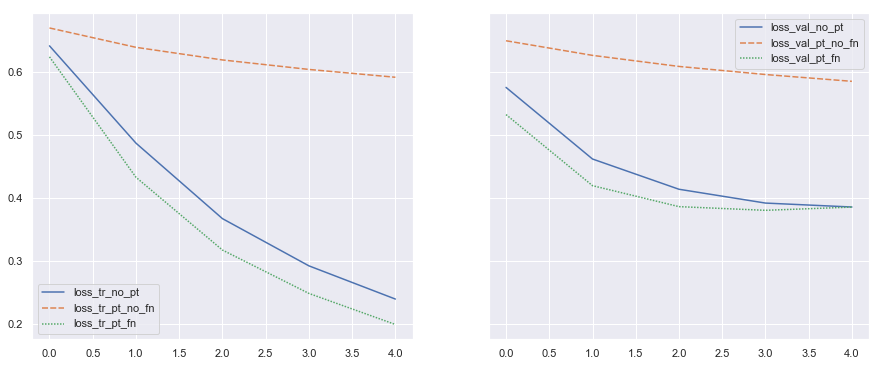

In [ ]:
sns.set(rc={'figure.figsize':(15, 6)})
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.lineplot(data=df[[col for col in df.columns if col.startswith("loss_tr")]], ax=ax1)
sns.lineplot(data=df[[col for col in df.columns if col.startswith("loss_val")]], ax=ax2)

**Comment**  

We are interesting in camparing the losses of the 3 cases at the training and validation phases:
* The Pre-training **with fine-tuning** outperforms again the pre-training **without fine-tuning** in both training and validation stages, in fact, the two losses of **without fine-tuning** version are decreasing in a lower slope than **with fine-tuning.**
* The Pre-training **with fine-tuning** and **no pre-training** have quite the same behavior at the training phase, they begin with near values and started to get far from each other after the second epoch **(point 1 in the x-axis)** while maintaning the same direction changes like in the fourth epoch **(point 3 in the x-axis).** For the validation phase, the both converge to the same values after the fourth epoch.


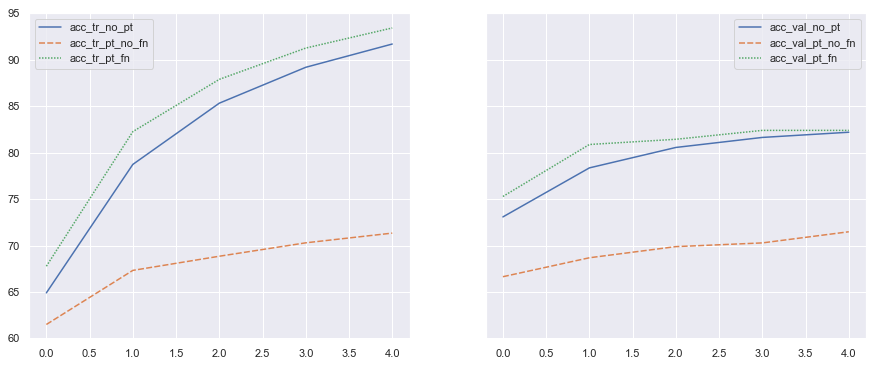

In [ ]:
sns.set(rc={'figure.figsize':(15, 6)})
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.lineplot(data=df[[col for col in df.columns if col.startswith("acc_tr")]], ax=ax1)
sns.lineplot(data=df[[col for col in df.columns if col.startswith("acc_val")]], ax=ax2)

**Comment**

The observations related about losses are the same from the accuracies point of view. 

### Question 2

In this part, we are interesting in doing some experiments for the 3 cases **no pre-training, pre-training without fine-tuning and pre-training with fine-tuning**, we will focus on variating the **number of documents** and the **size of the vocabulary.**

#### 1. Number of documents

We will keep the size of the vocabulary constant (min frequence = 5) and we will change the values of **the number of documents.** To do so, we will loop over the **portions** list, and at each iteration we will generate data and save the necessary results into dictionaries.

##### 1.1  Hypothesis

We assume that when the number of documents increases to the total length (25 000), the accuracy will also increase since we are taking into account more and more data in the training process, the model will then have the ability to learn more. 

##### 1.2  Experiments

In [ ]:
# 0 means to keep all the number of documents in the function get_splits
portions = [0.2, 0.4, 0.6, 0.8, 0]
splits = (0.8, 0.1)

In [ ]:
# save the training and validation accuracies for no pre-training version.
acc_tr_no_pt_dic = {}
acc_val_no_pt_dic = {}
# save the training and validation accuracies for no pre-training without fine-tuning version.
acc_tr_pt_no_fn_dic = {}
acc_val_pt_no_fn_dic = {}
# save the training and validation accuracies for no pre-training with fine-tuning version.
acc_tr_pt_fn_dic = {} 
acc_val_pt_fn_dic = {}
# save the accuracies on the testing set.
acc_test_no_pt_dic = {}
acc_test_pt_no_fn_dic  = {}
acc_test_pt_fn_dic = {}
for p in portions:
    print("-----Generating Data for portion: "+str(p)+"-----")
    (train_f, train_c), (valid_f, valid_c), (test_f, test_c) = get_splits(filenames, categories, splits, portion = p)
    training_dataset = TextClassificationDataset(train_f, train_c)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    
    # No pre-training model
    print("No pre-training model...")
    model_1, opt, criterion = initialize_model(AveragingModel, 300, len(training_word2idx))
    _, loss_tr_no_pt, loss_val_no_pt, acc_tr_no_pt, acc_val_no_pt = experiment(model_1, opt, criterion, early_stopping = False)
    _, test_acc = eval_model(model_1, criterion, test_dataloader)
    acc_tr_no_pt_dic[p] = acc_tr_no_pt
    acc_val_no_pt_dic[p] = acc_val_no_pt
    acc_test_no_pt_dic[p] = test_acc
    
    GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
    # pre-training without fine-tuning
    print("Pre-training without fine-tuning...")
    model_2, opt, criterion = initialize_model(PretrainedAveragingModel,embedding_dim = GloveEmbeddings.shape[1],
                                             embeddings = GloveEmbeddings, glove=True)
    _, loss_tr_pt_no_fn, loss_val_pt_no_fn, acc_tr_pt_no_fn, acc_val_pt_no_fn = experiment(model_2, opt, criterion, early_stopping = False)
    _, test_acc = eval_model(model_2, criterion, test_dataloader)
    
    acc_tr_pt_no_fn_dic[p] = acc_tr_pt_no_fn
    acc_val_pt_no_fn_dic[p] = acc_val_pt_no_fn
    acc_test_pt_no_fn_dic[p] = test_acc
    
    # pre-training with fine-tuning
    print("Pre-training with fine-tuning...")
    model_3, opt, criterion = initialize_model(PretrainedAveragingModel, embedding_dim = GloveEmbeddings.shape[1],
                                             embeddings = GloveEmbeddings, glove=True, non_trainable = True)
    _, loss_tr_pt_fn, loss_val_pt_fn, acc_tr_pt_fn, acc_val_pt_fn = experiment(model_3, opt, criterion, early_stopping = False)
    _, test_acc = eval_model(model_3, criterion, test_dataloader)
    
    acc_tr_pt_fn_dic[p] = acc_tr_pt_fn
    acc_val_pt_fn_dic[p] = acc_val_pt_fn
    acc_test_pt_fn_dic[p] = test_acc

-----Generating Data for portion: 0.2-----


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:09<00:00, 419.42it/s]


No pre-training model...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Epoch 1 : Training loss = 0.6830501556396484; Training acc = 56.25
Epoch 1 : Validation loss = 0.6809520959854126; Validation acc = 57.2


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Epoch 2 : Training loss = 0.6590591579675674; Training acc = 64.725
Epoch 2 : Validation loss = 0.6652551800012588; Validation acc = 61.8


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Epoch 3 : Training loss = 0.6294894248247147; Training acc = 70.275
Epoch 3 : Validation loss = 0.643581423163414; Validation acc = 64.0


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Epoch 4 : Training loss = 0.5890948474407196; Training acc = 73.875
Epoch 4 : Validation loss = 0.6164055407047272; Validation acc = 66.4


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Epoch 5 : Training loss = 0.5379153177142143; Training acc = 78.525
Epoch 5 : Validation loss = 0.5844065248966217; Validation acc = 69.8
Epoch 5 : Test loss = 0.5771461397409439; Test acc = 73.8
Pre-training without fine-tuning...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.14it/s]


Epoch 1 : Training loss = 0.6878868907690048; Training acc = 53.525
Epoch 1 : Validation loss = 0.6819105982780457; Validation acc = 61.6


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.34it/s]


Epoch 2 : Training loss = 0.6777204245328903; Training acc = 63.225
Epoch 2 : Validation loss = 0.6741208970546723; Validation acc = 61.0


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.50it/s]


Epoch 3 : Training loss = 0.669190526008606; Training acc = 65.25
Epoch 3 : Validation loss = 0.6669337838888169; Validation acc = 63.4


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.78it/s]


Epoch 4 : Training loss = 0.6619078636169433; Training acc = 64.65
Epoch 4 : Validation loss = 0.6611620604991912; Validation acc = 63.8


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.22it/s]


Epoch 5 : Training loss = 0.6571854203939438; Training acc = 65.425
Epoch 5 : Validation loss = 0.657721558213234; Validation acc = 62.4
Epoch 5 : Test loss = 0.6585991263389588; Test acc = 63.0
Pre-training with fine-tuning...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.42it/s]


Epoch 1 : Training loss = 0.6833442598581314; Training acc = 57.225
Epoch 1 : Validation loss = 0.6738413721323013; Validation acc = 61.6


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.44it/s]


Epoch 2 : Training loss = 0.6542610794305801; Training acc = 69.85
Epoch 2 : Validation loss = 0.650243267416954; Validation acc = 63.8


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 3 : Training loss = 0.6100950062274932; Training acc = 73.975
Epoch 3 : Validation loss = 0.6137103617191315; Validation acc = 68.6


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.47it/s]


Epoch 4 : Training loss = 0.5493430703878402; Training acc = 78.2
Epoch 4 : Validation loss = 0.5780351743102073; Validation acc = 70.6


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.41it/s]


Epoch 5 : Training loss = 0.47885611057281496; Training acc = 82.725
Epoch 5 : Validation loss = 0.5280780926346779; Validation acc = 74.4
Epoch 5 : Test loss = 0.5443810999393464; Test acc = 74.6
-----Generating Data for portion: 0.4-----


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:17<00:00, 465.29it/s]


No pre-training model...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.33it/s]


Epoch 1 : Training loss = 0.6793612942099572; Training acc = 56.8875
Epoch 1 : Validation loss = 0.6624093040823936; Validation acc = 63.4


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.33it/s]


Epoch 2 : Training loss = 0.63049156665802; Training acc = 68.625
Epoch 2 : Validation loss = 0.6047143921256065; Validation acc = 72.1


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.54it/s]


Epoch 3 : Training loss = 0.554034774005413; Training acc = 75.725
Epoch 3 : Validation loss = 0.5402310118079185; Validation acc = 75.1


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.36it/s]


Epoch 4 : Training loss = 0.4658379264175892; Training acc = 81.25
Epoch 4 : Validation loss = 0.48289711102843286; Validation acc = 78.3


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.31it/s]


Epoch 5 : Training loss = 0.3878186360001564; Training acc = 85.35
Epoch 5 : Validation loss = 0.44360089898109434; Validation acc = 80.2
Epoch 5 : Test loss = 0.46785776168107984; Test acc = 77.5
Pre-training without fine-tuning...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.39it/s]


Epoch 1 : Training loss = 0.683078096807003; Training acc = 57.075
Epoch 1 : Validation loss = 0.6733005821704865; Validation acc = 63.8


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.67it/s]


Epoch 2 : Training loss = 0.6659162834286689; Training acc = 64.0375
Epoch 2 : Validation loss = 0.6566094160079956; Validation acc = 66.0


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.63it/s]


Epoch 3 : Training loss = 0.6531437382102012; Training acc = 65.1875
Epoch 3 : Validation loss = 0.6479574054479599; Validation acc = 67.7


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.42it/s]


Epoch 4 : Training loss = 0.6426400616765022; Training acc = 67.0125
Epoch 4 : Validation loss = 0.6362153381109238; Validation acc = 68.9


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.96it/s]


Epoch 5 : Training loss = 0.6335776269435882; Training acc = 67.6375
Epoch 5 : Validation loss = 0.6273978680372239; Validation acc = 70.2
Epoch 5 : Test loss = 0.6267702087759972; Test acc = 69.8
Pre-training with fine-tuning...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:18<00:00,  2.12it/s]


Epoch 1 : Training loss = 0.6756851837038994; Training acc = 60.8375
Epoch 1 : Validation loss = 0.6491415068507195; Validation acc = 66.9


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:18<00:00,  2.22it/s]


Epoch 2 : Training loss = 0.6037069633603096; Training acc = 72.05
Epoch 2 : Validation loss = 0.5707785531878471; Validation acc = 73.9


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:18<00:00,  2.20it/s]


Epoch 3 : Training loss = 0.49138220623135564; Training acc = 80.25
Epoch 3 : Validation loss = 0.486197217553854; Validation acc = 78.5


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.22it/s]


Epoch 4 : Training loss = 0.3915004350244999; Training acc = 85.2375
Epoch 4 : Validation loss = 0.4414451241493225; Validation acc = 79.2


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:18<00:00,  2.20it/s]


Epoch 5 : Training loss = 0.31521028429269793; Training acc = 89.3875
Epoch 5 : Validation loss = 0.41545924469828605; Validation acc = 80.5
Epoch 5 : Test loss = 0.43092037439346315; Test acc = 80.3
-----Generating Data for portion: 0.6-----


100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:26<00:00, 456.50it/s]


No pre-training model...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:21<00:00,  2.83it/s]


Epoch 1 : Training loss = 0.6631189972162247; Training acc = 62.0
Epoch 1 : Validation loss = 0.6253152420123418; Validation acc = 69.6


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  2.93it/s]


Epoch 2 : Training loss = 0.5709279725948969; Training acc = 74.0
Epoch 2 : Validation loss = 0.5342012003064156; Validation acc = 76.06666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  2.93it/s]


Epoch 3 : Training loss = 0.45707854827245076; Training acc = 81.25
Epoch 3 : Validation loss = 0.4703888202706973; Validation acc = 78.13333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  2.89it/s]


Epoch 4 : Training loss = 0.3657553493976593; Training acc = 86.4
Epoch 4 : Validation loss = 0.43755803232391677; Validation acc = 80.13333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  2.92it/s]


Epoch 5 : Training loss = 0.2993805150190989; Training acc = 89.49166666666666
Epoch 5 : Validation loss = 0.4208415386577447; Validation acc = 81.46666666666667
Epoch 5 : Test loss = 0.41744513586163523; Test acc = 82.0
Pre-training without fine-tuning...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.13it/s]


Epoch 1 : Training loss = 0.6805489857991537; Training acc = 60.11666666666667
Epoch 1 : Validation loss = 0.6680988212426503; Validation acc = 64.06666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.14it/s]


Epoch 2 : Training loss = 0.6587487002213795; Training acc = 65.125
Epoch 2 : Validation loss = 0.6499175330003103; Validation acc = 66.8


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.45it/s]


Epoch 3 : Training loss = 0.6428662141164144; Training acc = 66.86666666666666
Epoch 3 : Validation loss = 0.6394373089075088; Validation acc = 66.66666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.71it/s]


Epoch 4 : Training loss = 0.6298447122176488; Training acc = 68.15
Epoch 4 : Validation loss = 0.6247584382692973; Validation acc = 69.33333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.69it/s]


Epoch 5 : Training loss = 0.6192262550195058; Training acc = 69.26666666666667
Epoch 5 : Validation loss = 0.6156394263108571; Validation acc = 68.86666666666666
Epoch 5 : Test loss = 0.6116104642550151; Test acc = 69.06666666666666
Pre-training with fine-tuning...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:30<00:00,  1.99it/s]


Epoch 1 : Training loss = 0.6590254078308742; Training acc = 63.458333333333336
Epoch 1 : Validation loss = 0.6092653373877207; Validation acc = 72.73333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:29<00:00,  2.04it/s]


Epoch 2 : Training loss = 0.5299461041887601; Training acc = 77.7
Epoch 2 : Validation loss = 0.4907158613204956; Validation acc = 78.53333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:29<00:00,  2.04it/s]


Epoch 3 : Training loss = 0.3974403038620949; Training acc = 84.725
Epoch 3 : Validation loss = 0.43710348109404246; Validation acc = 80.06666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:29<00:00,  2.04it/s]


Epoch 4 : Training loss = 0.30944155926505723; Training acc = 88.90833333333333
Epoch 4 : Validation loss = 0.41446217770377797; Validation acc = 80.93333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:29<00:00,  2.02it/s]


Epoch 5 : Training loss = 0.2466203103462855; Training acc = 91.95833333333333
Epoch 5 : Validation loss = 0.41855120435357096; Validation acc = 81.06666666666666
Epoch 5 : Test loss = 0.40673299903670945; Test acc = 82.26666666666667
-----Generating Data for portion: 0.8-----


100%|███████████████████████████████████████████████████████████████████████████| 16000/16000 [00:34<00:00, 458.46it/s]


No pre-training model...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:29<00:00,  2.73it/s]


Epoch 1 : Training loss = 0.653717303276062; Training acc = 63.225
Epoch 1 : Validation loss = 0.607543383538723; Validation acc = 69.6


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:28<00:00,  2.81it/s]


Epoch 2 : Training loss = 0.5292190324515105; Training acc = 76.0875
Epoch 2 : Validation loss = 0.4944905012845993; Validation acc = 77.95


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch 3 : Training loss = 0.40640919245779517; Training acc = 83.425
Epoch 3 : Validation loss = 0.43320692107081415; Validation acc = 80.8


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch 4 : Training loss = 0.32380591332912445; Training acc = 87.76875
Epoch 4 : Validation loss = 0.40611776560544965; Validation acc = 82.4


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:28<00:00,  2.85it/s]


Epoch 5 : Training loss = 0.2648572029545903; Training acc = 90.5625
Epoch 5 : Validation loss = 0.3957052879035473; Validation acc = 82.85
Epoch 5 : Test loss = 0.38572419472038744; Test acc = 81.7
Pre-training without fine-tuning...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:06<00:00, 12.58it/s]


Epoch 1 : Training loss = 0.6745446771383286; Training acc = 61.0875
Epoch 1 : Validation loss = 0.6563043870031834; Validation acc = 66.4


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:06<00:00, 12.90it/s]


Epoch 2 : Training loss = 0.6465885221958161; Training acc = 66.44375
Epoch 2 : Validation loss = 0.6341165266931057; Validation acc = 66.65


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:06<00:00, 12.81it/s]


Epoch 3 : Training loss = 0.6276730678975582; Training acc = 68.15
Epoch 3 : Validation loss = 0.6184258766472339; Validation acc = 67.75


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:06<00:00, 12.74it/s]


Epoch 4 : Training loss = 0.613664461672306; Training acc = 69.14375
Epoch 4 : Validation loss = 0.6057153351604938; Validation acc = 69.35


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:06<00:00, 12.69it/s]


Epoch 5 : Training loss = 0.6023625336587429; Training acc = 70.08125
Epoch 5 : Validation loss = 0.5944474764168263; Validation acc = 70.9
Epoch 5 : Test loss = 0.5994086772203445; Test acc = 71.25
Pre-training with fine-tuning...
Beginning training...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:43<00:00,  1.84it/s]


Epoch 1 : Training loss = 0.6479066468775272; Training acc = 64.26875
Epoch 1 : Validation loss = 0.5800287589430809; Validation acc = 72.45


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:42<00:00,  1.90it/s]


Epoch 2 : Training loss = 0.4858937419950962; Training acc = 79.34375
Epoch 2 : Validation loss = 0.44854471310973165; Validation acc = 81.05


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:42<00:00,  1.90it/s]


Epoch 3 : Training loss = 0.35381305292248727; Training acc = 86.34375
Epoch 3 : Validation loss = 0.40375851579010485; Validation acc = 82.35


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:44<00:00,  1.82it/s]


Epoch 4 : Training loss = 0.27483865078538655; Training acc = 90.15
Epoch 4 : Validation loss = 0.39294276423752306; Validation acc = 82.1


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:46<00:00,  1.73it/s]


Epoch 5 : Training loss = 0.21907792892307043; Training acc = 92.6125
Epoch 5 : Validation loss = 0.38938936199992896; Validation acc = 82.65
Epoch 5 : Test loss = 0.3843272829428315; Test acc = 82.55
-----Generating Data for portion: 0-----


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:51<00:00, 389.34it/s]


No pre-training model...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.53it/s]


Epoch 1 : Training loss = 0.6448220866918564; Training acc = 64.925
Epoch 1 : Validation loss = 0.5752857136726379; Validation acc = 72.28


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.56it/s]


Epoch 2 : Training loss = 0.4920204356312752; Training acc = 78.29
Epoch 2 : Validation loss = 0.45170472502708436; Validation acc = 80.12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57it/s]


Epoch 3 : Training loss = 0.3691256755590439; Training acc = 85.435
Epoch 3 : Validation loss = 0.40184109315276145; Validation acc = 81.96


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.69it/s]


Epoch 4 : Training loss = 0.2937198108434677; Training acc = 89.205
Epoch 4 : Validation loss = 0.3842994454503059; Validation acc = 82.84


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.74it/s]


Epoch 5 : Training loss = 0.2406909656524658; Training acc = 91.525
Epoch 5 : Validation loss = 0.3794152010977268; Validation acc = 83.32
Epoch 5 : Test loss = 0.3696421226859093; Test acc = 83.88
Pre-training without fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.76it/s]


Epoch 1 : Training loss = 0.6691932666301728; Training acc = 63.855
Epoch 1 : Validation loss = 0.6483956670761108; Validation acc = 66.64


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.25it/s]


Epoch 2 : Training loss = 0.6383606094121933; Training acc = 67.1
Epoch 2 : Validation loss = 0.6283794349431991; Validation acc = 66.76


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.78it/s]


Epoch 3 : Training loss = 0.6188580572605134; Training acc = 68.94
Epoch 3 : Validation loss = 0.6075772047042847; Validation acc = 69.68


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.76it/s]


Epoch 4 : Training loss = 0.6036360013484955; Training acc = 70.475
Epoch 4 : Validation loss = 0.5936890524625779; Validation acc = 70.76


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


Epoch 5 : Training loss = 0.5920653194189072; Training acc = 71.26
Epoch 5 : Validation loss = 0.5821897926926612; Validation acc = 71.52
Epoch 5 : Test loss = 0.5825624617934227; Test acc = 72.0
Pre-training with fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


Epoch 1 : Training loss = 0.6232141441106797; Training acc = 68.545
Epoch 1 : Validation loss = 0.5250198391079902; Validation acc = 75.72


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


Epoch 2 : Training loss = 0.4306430268287659; Training acc = 82.13
Epoch 2 : Validation loss = 0.4099312083423138; Validation acc = 81.6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


Epoch 3 : Training loss = 0.31522844940423966; Training acc = 87.985
Epoch 3 : Validation loss = 0.3802961517870426; Validation acc = 83.04


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s]


Epoch 4 : Training loss = 0.24564106315374373; Training acc = 91.405
Epoch 4 : Validation loss = 0.37624517306685445; Validation acc = 84.04


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


Epoch 5 : Training loss = 0.1963245590031147; Training acc = 93.55
Epoch 5 : Validation loss = 0.38417754620313643; Validation acc = 83.2
Epoch 5 : Test loss = 0.36830723643302915; Test acc = 84.24


##### 1.3 Results and Analysis

The results are saved in dataframe, we run all model versions for **5 epochs** for each portion of documents. For each portion, we have then **5 values** for training and validation phases, and **one value** for testing set.

In [ ]:
# We will save the results as Dataframe
import pandas as pd
df = pd.DataFrame(list(zip(acc_tr_no_pt_dic.keys(), acc_tr_no_pt_dic.values(), acc_val_no_pt_dic.values(),
                           acc_tr_pt_no_fn_dic.values(), acc_val_pt_no_fn_dic.values(), acc_tr_pt_fn_dic.values(), 
                           acc_val_pt_fn_dic.values(), acc_test_no_pt_dic.values(), acc_test_pt_no_fn_dic.values(),
                           acc_test_pt_fn_dic.values())),
               columns =['portion','acc_tr_no_pt_dic', 'acc_val_no_pt_dic', 'acc_tr_pt_no_fn_dic', 
                         'acc_val_pt_no_fn_dic', 'acc_tr_pt_fn_dic', 'acc_val_pt_fn_dic', 'acc_test_no_pt_dic',
                         'acc_test_pt_no_fn_dic', 'acc_test_pt_fn_dic'])
df["portion"][4] = 1
df

C:\Users\asus\Anaconda3v2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,portion,acc_tr_no_pt_dic,acc_val_no_pt_dic,acc_tr_pt_no_fn_dic,acc_val_pt_no_fn_dic,acc_tr_pt_fn_dic,acc_val_pt_fn_dic,acc_test_no_pt_dic,acc_test_pt_no_fn_dic,acc_test_pt_fn_dic
0,0.2,"[56.25, 64.725, 70.275, 73.875, 78.525]","[57.2, 61.8, 64.0, 66.4, 69.8]","[53.525, 63.225, 65.25, 64.65, 65.425]","[61.6, 61.0, 63.4, 63.8, 62.4]","[57.225, 69.85, 73.975, 78.2, 82.725]","[61.6, 63.8, 68.6, 70.6, 74.4]",73.80,63.000000,74.600000
1,0.4,"[56.8875, 68.625, 75.725, 81.25, 85.35]","[63.4, 72.1, 75.1, 78.3, 80.2]","[57.075, 64.0375, 65.1875, 67.0125, 67.6375]","[63.8, 66.0, 67.7, 68.9, 70.2]","[60.8375, 72.05, 80.25, 85.2375, 89.3875]","[66.9, 73.9, 78.5, 79.2, 80.5]",77.50,69.800000,80.300000
2,0.6,"[62.0, 74.0, 81.25, 86.4, 89.49166666666666]","[69.6, 76.06666666666666, 78.13333333333334, 8...","[60.11666666666667, 65.125, 66.86666666666666,...","[64.06666666666666, 66.8, 66.66666666666667, 6...","[63.458333333333336, 77.7, 84.725, 88.90833333...","[72.73333333333333, 78.53333333333333, 80.0666...",82.00,69.066667,82.266667
3,0.8,"[63.225, 76.0875, 83.425, 87.76875, 90.5625]","[69.6, 77.95, 80.8, 82.4, 82.85]","[61.0875, 66.44375, 68.15, 69.14375, 70.08125]","[66.4, 66.65, 67.75, 69.35, 70.9]","[64.26875, 79.34375, 86.34375, 90.15, 92.6125]","[72.45, 81.05, 82.35, 82.1, 82.65]",81.70,71.250000,82.550000
4,1.0,"[64.925, 78.29, 85.435, 89.205, 91.525]","[72.28, 80.12, 81.96, 82.84, 83.32]","[63.855, 67.1, 68.94, 70.475, 71.26]","[66.64, 66.76, 69.68, 70.76, 71.52]","[68.545, 82.13, 87.985, 91.405, 93.55]","[75.72, 81.6, 83.04, 84.04, 83.2]",83.88,72.000000,84.240000


Text(0.5, 1.0, 'Variation of accuracies on testing set')

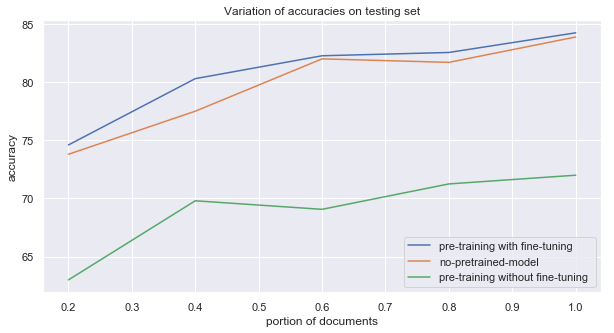

In [ ]:
sns.set(rc={'figure.figsize':(10, 5)})
fig, ax1 = plt.subplots(ncols=1, sharey=True)
ax1.set_xlabel("portion of documents")
ax1.set_ylabel("accuracy")
sns.lineplot(x=df.portion, y=df.acc_test_pt_fn_dic, label="pre-training with fine-tuning",ax=ax1)
sns.lineplot(x=df.portion, y=df.acc_test_no_pt_dic, label="no-pretrained-model",ax=ax1)
sns.lineplot(x=df.portion, y=df.acc_test_pt_no_fn_dic, label="pre-training without fine-tuning ",ax=ax1)
ax1.legend()
ax1.set_title('Variation of accuracies on testing set')

**Comment**

We start our analysis by camparing the 3 cases on the **testing set**, all the models accuracies **are increasing** in general, when the number of **documents increases.** The **no-pretrained-model** and **pre-training with fine-tuning** converges to the same accuracy almost when training with the **total number of documents (portion = 1).**

Next, we will focus on each case separatly, we will consider both the training and validation phases, and accracy as metric for evaluation.

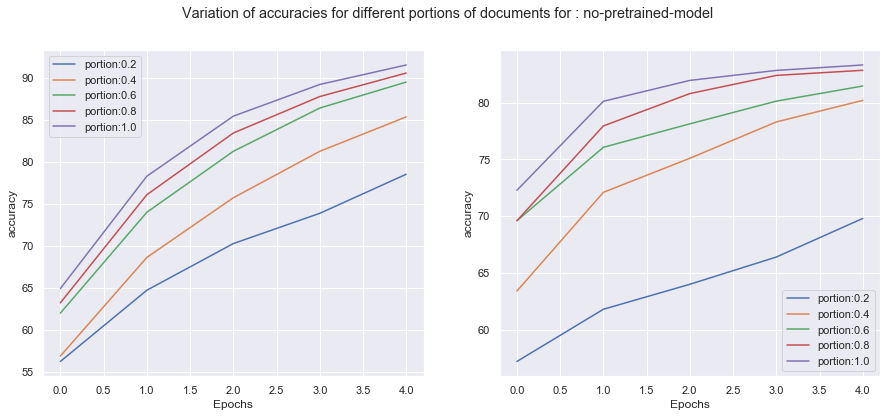

In [ ]:
plot_results(df.acc_tr_no_pt_dic, df.acc_val_no_pt_dic, "no-pretrained-model")

**Comment**

* In the **training phase: (on the left)** we can see that for all portion values, the accuracy is increasing. In particular, the portions **0.6, 0.8 and 1** have almost the same behavior, same direction changes at epochs **2,3 and 4** (points 1,2 and 3). 
* In the **validation phase: (on the right)** we observe the same general behavior as for the training phase, the portions **0.8 and 1** tend to the same accuracy after the fifth epoch. 

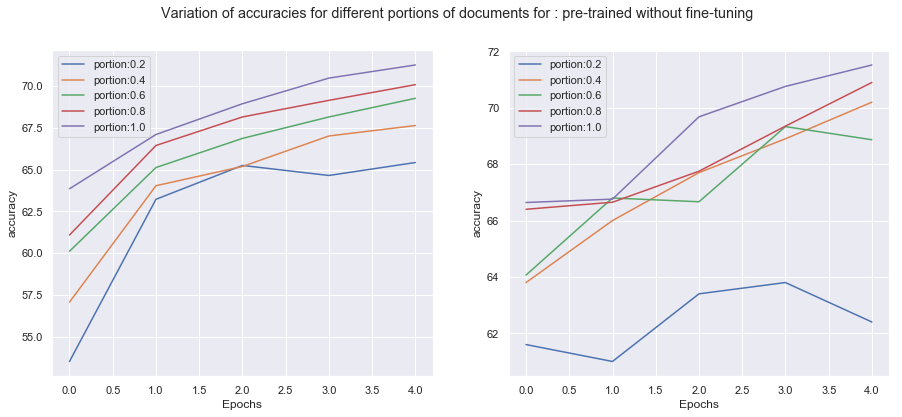

In [ ]:
plot_results(df.acc_tr_pt_no_fn_dic, df.acc_val_pt_no_fn_dic, "pre-trained without fine-tuning")

**Comment**

* In the **training phase: (on the left)** same general behavior as for **no-pretrained-model**, except for the portion **0.2** at the fourth epoch, where we observe a drop of the accuracy. all the portions values stayed near each other, until the **third epoch** (point 2 on the graph).
* In the **validation phase: (on the right)** for the portions **0.4, 0.8 and 1**, the accuracy is increasing with **linear behavior** for portion 0.1, for the portions 0.6 and 0.2 the is no **regular behavior.**

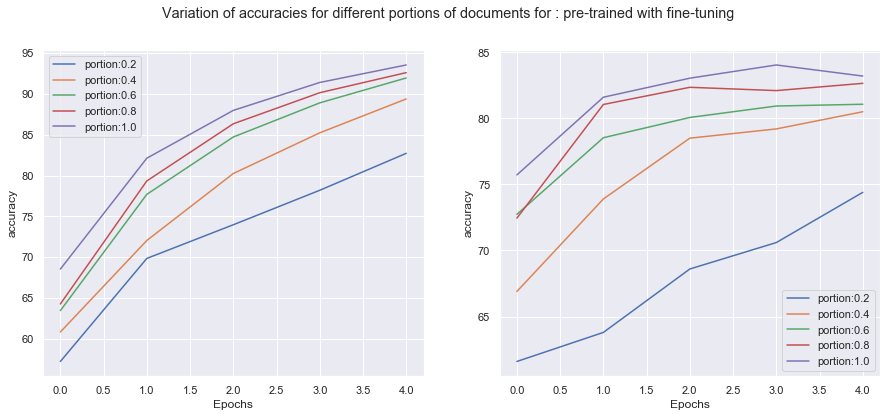

In [ ]:
plot_results(df.acc_tr_pt_fn_dic, df.acc_val_pt_fn_dic, "pre-trained with fine-tuning")

**Comment**

* In the **training phase: (on the left)** same general behavior as for **no-pretrained-model**, linear increase for portion **0.2** after the second epoch.
* In the **validation phase: (on the right)** general increase for all portions with different rates, **portion 1** gives the best results with a sligt drop after the **fourth epoch.**

##### 1.4 Conclusion

We can say that the experiments validate our hypothesis in the testing set, and both at the training and validation phases for **no-pretrained-model** version and **pre-trained with fine-tuning**, and at the training phases for the **pre-trained without fine-tuning**

#### 2. Minimum frequency

We will keep the the **number of documents** constant (25 000) and we will change the values of **size of the vocabulary,** we will generate data once. To do so, we will loop over the min_frequences list, and at each iteration we update the data and save the necessary results into dictionaries.

##### 2.1 Hypothesis

We consider as hypothesis that when decreasing the increasing the **minimum freqency**, the accuracy will decrease, since the model will have to deal just with the words that are frequent and ignore the rare ones that can have **unique meaning** in the sentence.

##### 2.2 Experiments

In [ ]:
min_frequences = [1, 2, 5, 10, 15]
splits = (0.8, 0.1)
(train_f, train_c), (valid_f, valid_c), (test_f, test_c) = get_splits(filenames, categories, splits)

In [ ]:
# save the training and validation accuracies for no pre-training version.
acc_tr_no_pt_dic = {}
acc_val_no_pt_dic = {}
# save the training and validation accuracies for no pre-training without fine-tuning version.
acc_tr_pt_no_fn_dic = {}
acc_val_pt_no_fn_dic = {}
# save the training and validation accuracies for no pre-training with fine-tuning version.
acc_tr_pt_fn_dic = {} 
acc_val_pt_fn_dic = {}
# save the accuracies on the testing set.
acc_test_no_pt_dic = {}
acc_test_pt_no_fn_dic  = {}
acc_test_pt_fn_dic = {}
for freq in min_frequences:
    print("-----Generating Data for min frequence: "+str(freq)+"-----")
    training_dataset = TextClassificationDataset(train_f, train_c, min_freq = freq)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word), min_freq = freq)
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word), min_freq = freq)
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    
    # No pre-training model
    print("No pre-training model...")
    model_1, opt, criterion = initialize_model(AveragingModel, 300, len(training_word2idx))
    _, loss_tr_no_pt, loss_val_no_pt, acc_tr_no_pt, acc_val_no_pt = experiment(model_1, opt, criterion, early_stopping = False)
    _, test_acc = eval_model(model_1, criterion, test_dataloader)
    acc_tr_no_pt_dic[freq] = acc_tr_no_pt
    acc_val_no_pt_dic[freq] = acc_val_no_pt
    acc_test_no_pt_dic[freq] = test_acc
    
    GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
    # pre-training without fine-tuning
    print("Pre-training without fine-tuning...")
    model_2, opt, criterion = initialize_model(PretrainedAveragingModel,embedding_dim = GloveEmbeddings.shape[1],
                                             embeddings = GloveEmbeddings, glove=True)
    _, loss_tr_pt_no_fn, loss_val_pt_no_fn, acc_tr_pt_no_fn, acc_val_pt_no_fn = experiment(model_2, opt, criterion, early_stopping = False)
    _, test_acc = eval_model(model_2, criterion, test_dataloader)
    
    acc_tr_pt_no_fn_dic[freq] = acc_tr_pt_no_fn
    acc_val_pt_no_fn_dic[freq] = acc_val_pt_no_fn
    acc_test_pt_no_fn_dic[freq] = test_acc
    
    # pre-training with fine-tuning
    print("Pre-training with fine-tuning...")
    model_3, opt, criterion = initialize_model(PretrainedAveragingModel, embedding_dim = GloveEmbeddings.shape[1],
                                             embeddings = GloveEmbeddings, glove=True, non_trainable = True)
    _, loss_tr_pt_fn, loss_val_pt_fn, acc_tr_pt_fn, acc_val_pt_fn = experiment(model_3, opt, criterion, early_stopping = False)
    _, test_acc = eval_model(model_3, criterion, test_dataloader)
    
    acc_tr_pt_fn_dic[freq] = acc_tr_pt_fn
    acc_val_pt_fn_dic[freq] = acc_val_pt_fn
    acc_test_pt_fn_dic[freq] = test_acc

-----Generating Data for min frequence: 1-----


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:44<00:00, 446.22it/s]


No pre-training model...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Epoch 1 : Training loss = 0.6428741770982742; Training acc = 64.595
Epoch 1 : Validation loss = 0.5789279714226723; Validation acc = 72.68


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s]


Epoch 2 : Training loss = 0.48495945185422895; Training acc = 79.015
Epoch 2 : Validation loss = 0.45529047429561614; Validation acc = 79.2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 3 : Training loss = 0.35354111313819886; Training acc = 86.445
Epoch 3 : Validation loss = 0.4049995774030685; Validation acc = 82.4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s]


Epoch 4 : Training loss = 0.27045938700437544; Training acc = 90.585
Epoch 4 : Validation loss = 0.38880098447203637; Validation acc = 82.64


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


Epoch 5 : Training loss = 0.21114420309662818; Training acc = 92.95
Epoch 5 : Validation loss = 0.39118464663624763; Validation acc = 82.96
Epoch 5 : Test loss = 0.381041235178709; Test acc = 83.36
Pre-training without fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.67it/s]


Epoch 1 : Training loss = 0.6703061300516129; Training acc = 63.35
Epoch 1 : Validation loss = 0.6521813470125198; Validation acc = 66.96


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.72it/s]


Epoch 2 : Training loss = 0.6387734627723693; Training acc = 67.215
Epoch 2 : Validation loss = 0.6282154017686844; Validation acc = 69.24


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.39it/s]


Epoch 3 : Training loss = 0.61905657351017; Training acc = 68.62
Epoch 3 : Validation loss = 0.6102151989936828; Validation acc = 70.6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.38it/s]


Epoch 4 : Training loss = 0.603507691025734; Training acc = 70.375
Epoch 4 : Validation loss = 0.5962336531281471; Validation acc = 70.96


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.53it/s]


Epoch 5 : Training loss = 0.5914770466089249; Training acc = 71.02
Epoch 5 : Validation loss = 0.584470192193985; Validation acc = 72.84
Epoch 5 : Test loss = 0.5841775280237198; Test acc = 71.12
Pre-training with fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Epoch 1 : Training loss = 0.6207156819105148; Training acc = 68.03
Epoch 1 : Validation loss = 0.5246392101049423; Validation acc = 76.56


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


Epoch 2 : Training loss = 0.4221805927157402; Training acc = 83.01
Epoch 2 : Validation loss = 0.41279207333922385; Validation acc = 81.32


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Epoch 3 : Training loss = 0.2976968590915203; Training acc = 89.175
Epoch 3 : Validation loss = 0.3839869673550129; Validation acc = 82.92


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Epoch 4 : Training loss = 0.22031525433063506; Training acc = 92.59
Epoch 4 : Validation loss = 0.3868627570569515; Validation acc = 82.6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Epoch 5 : Training loss = 0.16542449176311494; Training acc = 95.08
Epoch 5 : Validation loss = 0.39504239603877067; Validation acc = 82.88
Epoch 5 : Test loss = 0.37761636547744276; Test acc = 83.8
-----Generating Data for min frequence: 2-----


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:42<00:00, 466.42it/s]


No pre-training model...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.04it/s]


Epoch 1 : Training loss = 0.6372417223453521; Training acc = 65.745
Epoch 1 : Validation loss = 0.5710257437825202; Validation acc = 72.36


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]


Epoch 2 : Training loss = 0.4783622106909752; Training acc = 79.6
Epoch 2 : Validation loss = 0.4478817045688629; Validation acc = 79.92


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.24it/s]


Epoch 3 : Training loss = 0.3548522081971168; Training acc = 86.345
Epoch 3 : Validation loss = 0.40382670536637305; Validation acc = 82.32


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]


Epoch 4 : Training loss = 0.27580094054341314; Training acc = 90.225
Epoch 4 : Validation loss = 0.38913832649588587; Validation acc = 82.4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.13it/s]


Epoch 5 : Training loss = 0.21989021256566046; Training acc = 92.695
Epoch 5 : Validation loss = 0.39629611998796466; Validation acc = 82.44
Epoch 5 : Test loss = 0.38310462445020677; Test acc = 83.28
Pre-training without fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.58it/s]


Epoch 1 : Training loss = 0.6696538364887238; Training acc = 63.06
Epoch 1 : Validation loss = 0.6514829188585282; Validation acc = 66.8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.73it/s]


Epoch 2 : Training loss = 0.6381140995025635; Training acc = 67.47
Epoch 2 : Validation loss = 0.6275568836927414; Validation acc = 69.12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.42it/s]


Epoch 3 : Training loss = 0.6179410952329636; Training acc = 68.86
Epoch 3 : Validation loss = 0.6098578810691834; Validation acc = 70.72


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 4 : Training loss = 0.6027571398019791; Training acc = 70.26
Epoch 4 : Validation loss = 0.5947726395726204; Validation acc = 71.6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.09it/s]


Epoch 5 : Training loss = 0.5901925081014633; Training acc = 71.325
Epoch 5 : Validation loss = 0.5843933206796647; Validation acc = 72.96
Epoch 5 : Test loss = 0.5836763331294059; Test acc = 71.2
Pre-training with fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 1 : Training loss = 0.6269518774747849; Training acc = 68.145
Epoch 1 : Validation loss = 0.5339292168617249; Validation acc = 76.28


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 2 : Training loss = 0.4292245468497276; Training acc = 82.515
Epoch 2 : Validation loss = 0.4182943530380726; Validation acc = 81.36


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


Epoch 3 : Training loss = 0.30584239184856415; Training acc = 88.765
Epoch 3 : Validation loss = 0.38859218791127204; Validation acc = 82.32


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Epoch 4 : Training loss = 0.230188589990139; Training acc = 92.16
Epoch 4 : Validation loss = 0.3833188131451607; Validation acc = 82.64


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Epoch 5 : Training loss = 0.17621626302599908; Training acc = 94.53
Epoch 5 : Validation loss = 0.39596734508872033; Validation acc = 82.68
Epoch 5 : Test loss = 0.380478013753891; Test acc = 83.08
-----Generating Data for min frequence: 5-----


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:49<00:00, 407.90it/s]


No pre-training model...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]


Epoch 1 : Training loss = 0.6445244663953781; Training acc = 64.53
Epoch 1 : Validation loss = 0.5819846352934838; Validation acc = 72.64


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.70it/s]


Epoch 2 : Training loss = 0.4916308084130287; Training acc = 78.71
Epoch 2 : Validation loss = 0.45731537967920305; Validation acc = 78.68


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Epoch 3 : Training loss = 0.3666423541307449; Training acc = 85.715
Epoch 3 : Validation loss = 0.40833904072642324; Validation acc = 81.24


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.59it/s]


Epoch 4 : Training loss = 0.29087680801749227; Training acc = 89.285
Epoch 4 : Validation loss = 0.3920642918348312; Validation acc = 81.88


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


Epoch 5 : Training loss = 0.23766929879784585; Training acc = 91.71
Epoch 5 : Validation loss = 0.3910964946448803; Validation acc = 82.08
Epoch 5 : Test loss = 0.3784878180921078; Test acc = 83.72
Pre-training without fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.65it/s]


Epoch 1 : Training loss = 0.6675528359413146; Training acc = 62.63
Epoch 1 : Validation loss = 0.6499627894163131; Validation acc = 66.52


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.47it/s]


Epoch 2 : Training loss = 0.6373426288366317; Training acc = 67.11
Epoch 2 : Validation loss = 0.6270600748062134; Validation acc = 68.36


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.89it/s]


Epoch 3 : Training loss = 0.6180937469005585; Training acc = 68.965
Epoch 3 : Validation loss = 0.6095921877026558; Validation acc = 70.84


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.39it/s]


Epoch 4 : Training loss = 0.6037181323766708; Training acc = 69.895
Epoch 4 : Validation loss = 0.5967719188332558; Validation acc = 72.32


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.31it/s]


Epoch 5 : Training loss = 0.5908805793523788; Training acc = 71.225
Epoch 5 : Validation loss = 0.5841597655415535; Validation acc = 72.44
Epoch 5 : Test loss = 0.5839735019207001; Test acc = 71.24
Pre-training with fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s]


Epoch 1 : Training loss = 0.6262106031179429; Training acc = 67.435
Epoch 1 : Validation loss = 0.532170625925064; Validation acc = 76.32


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


Epoch 2 : Training loss = 0.4322074788808823; Training acc = 82.225
Epoch 2 : Validation loss = 0.4193468292057514; Validation acc = 81.04


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Epoch 3 : Training loss = 0.3169991871714592; Training acc = 87.955
Epoch 3 : Validation loss = 0.3890146750211716; Validation acc = 82.52


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


Epoch 4 : Training loss = 0.24690644398331643; Training acc = 91.15
Epoch 4 : Validation loss = 0.38435820132493975; Validation acc = 82.96


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]


Epoch 5 : Training loss = 0.19663039043545724; Training acc = 93.345
Epoch 5 : Validation loss = 0.3932471592724323; Validation acc = 82.64
Epoch 5 : Test loss = 0.3786352140456438; Test acc = 83.64
-----Generating Data for min frequence: 10-----


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:48<00:00, 414.40it/s]


No pre-training model...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.92it/s]


Epoch 1 : Training loss = 0.6459106242656708; Training acc = 64.07
Epoch 1 : Validation loss = 0.5810892829298973; Validation acc = 72.88


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.87it/s]


Epoch 2 : Training loss = 0.4944650396704674; Training acc = 78.505
Epoch 2 : Validation loss = 0.4586834681034088; Validation acc = 79.56


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]


Epoch 3 : Training loss = 0.3778217014670372; Training acc = 84.845
Epoch 3 : Validation loss = 0.4103140065073967; Validation acc = 81.96


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 4 : Training loss = 0.3077664104104042; Training acc = 88.155
Epoch 4 : Validation loss = 0.39410425841808316; Validation acc = 82.52


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.98it/s]


Epoch 5 : Training loss = 0.25891597017645834; Training acc = 90.385
Epoch 5 : Validation loss = 0.39327929764986036; Validation acc = 82.4
Epoch 5 : Test loss = 0.38568188190460206; Test acc = 83.12
Pre-training without fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.92it/s]


Epoch 1 : Training loss = 0.6712521493434906; Training acc = 61.82
Epoch 1 : Validation loss = 0.6530939906835556; Validation acc = 65.92


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.21it/s]


Epoch 2 : Training loss = 0.6402301615476609; Training acc = 66.9
Epoch 2 : Validation loss = 0.6295352190732956; Validation acc = 68.76


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.28it/s]


Epoch 3 : Training loss = 0.6204876601696014; Training acc = 68.475
Epoch 3 : Validation loss = 0.6130876106023788; Validation acc = 70.72


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.05it/s]


Epoch 4 : Training loss = 0.6056137651205062; Training acc = 69.84
Epoch 4 : Validation loss = 0.5981862244009971; Validation acc = 70.48


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.70it/s]


Epoch 5 : Training loss = 0.5933662688732148; Training acc = 70.92
Epoch 5 : Validation loss = 0.5867681747674942; Validation acc = 72.44
Epoch 5 : Test loss = 0.5859017267823219; Test acc = 70.84
Pre-training with fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch 1 : Training loss = 0.6272077971696853; Training acc = 67.295
Epoch 1 : Validation loss = 0.534264363348484; Validation acc = 75.52


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.01it/s]


Epoch 2 : Training loss = 0.4368383848667145; Training acc = 81.815
Epoch 2 : Validation loss = 0.41993466660380363; Validation acc = 81.64


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.04it/s]


Epoch 3 : Training loss = 0.32727310627698897; Training acc = 87.265
Epoch 3 : Validation loss = 0.39111347779631617; Validation acc = 82.84


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


Epoch 4 : Training loss = 0.26408004239201543; Training acc = 90.375
Epoch 4 : Validation loss = 0.38732069477438924; Validation acc = 82.84


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.01it/s]


Epoch 5 : Training loss = 0.2186253309249878; Training acc = 92.135
Epoch 5 : Validation loss = 0.39607270300388336; Validation acc = 82.64
Epoch 5 : Test loss = 0.3835092169046402; Test acc = 83.68
-----Generating Data for min frequence: 15-----


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:44<00:00, 452.99it/s]


No pre-training model...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 1 : Training loss = 0.6406192946434021; Training acc = 65.84
Epoch 1 : Validation loss = 0.5769680526852607; Validation acc = 73.36


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.24it/s]


Epoch 2 : Training loss = 0.49253424257040024; Training acc = 78.32
Epoch 2 : Validation loss = 0.4614490973949432; Validation acc = 78.76


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 3 : Training loss = 0.38156217157840727; Training acc = 84.59
Epoch 3 : Validation loss = 0.414200641810894; Validation acc = 81.52


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.36it/s]


Epoch 4 : Training loss = 0.31627448767423627; Training acc = 87.675
Epoch 4 : Validation loss = 0.3986734050512314; Validation acc = 81.88


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


Epoch 5 : Training loss = 0.2728134223818779; Training acc = 89.605
Epoch 5 : Validation loss = 0.39763195857405664; Validation acc = 82.12
Epoch 5 : Test loss = 0.39089192539453504; Test acc = 82.36
Pre-training without fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.72it/s]


Epoch 1 : Training loss = 0.6706529653072357; Training acc = 62.795
Epoch 1 : Validation loss = 0.6537389391660691; Validation acc = 65.52


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.79it/s]


Epoch 2 : Training loss = 0.6404899942874909; Training acc = 66.85
Epoch 2 : Validation loss = 0.6302299571037292; Validation acc = 67.8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.51it/s]


Epoch 3 : Training loss = 0.6212595337629319; Training acc = 68.47
Epoch 3 : Validation loss = 0.6127385187149048; Validation acc = 69.68


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.84it/s]


Epoch 4 : Training loss = 0.6067587363719941; Training acc = 69.63
Epoch 4 : Validation loss = 0.5997173002362252; Validation acc = 71.72


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.99it/s]


Epoch 5 : Training loss = 0.5944688796997071; Training acc = 70.77
Epoch 5 : Validation loss = 0.5873460358381272; Validation acc = 71.68
Epoch 5 : Test loss = 0.5866141128540039; Test acc = 70.96
Pre-training with fine-tuning...
Beginning training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.20it/s]


Epoch 1 : Training loss = 0.6211534464359283; Training acc = 68.335
Epoch 1 : Validation loss = 0.528118969798088; Validation acc = 76.16


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]


Epoch 2 : Training loss = 0.43806336760520936; Training acc = 81.695
Epoch 2 : Validation loss = 0.4201658123731613; Validation acc = 81.0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s]


Epoch 3 : Training loss = 0.3344018027186394; Training acc = 86.59
Epoch 3 : Validation loss = 0.3919458395242691; Validation acc = 82.56


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.14it/s]


Epoch 4 : Training loss = 0.27480870485305786; Training acc = 89.535
Epoch 4 : Validation loss = 0.39255109295248986; Validation acc = 82.72


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.22it/s]


Epoch 5 : Training loss = 0.23265669032931327; Training acc = 91.475
Epoch 5 : Validation loss = 0.3988345657289028; Validation acc = 82.48
Epoch 5 : Test loss = 0.387362854629755; Test acc = 83.48


##### 2.3 Results and Analysis

The results are saved in dataframe, we run all model versions for 5 epochs for each portion of documents. For each min frequence, we have then **5 values** for training and validation phases, and **one value** for testing set.

In [ ]:
# We will save the results as Dataframe
import pandas as pd
df = pd.DataFrame(list(zip(acc_tr_no_pt_dic.keys(), acc_tr_no_pt_dic.values(), acc_val_no_pt_dic.values(),
                           acc_tr_pt_no_fn_dic.values(), acc_val_pt_no_fn_dic.values(), acc_tr_pt_fn_dic.values(), 
                           acc_val_pt_fn_dic.values(), acc_test_no_pt_dic.values(), acc_test_pt_no_fn_dic.values(),
                           acc_test_pt_fn_dic.values())),
               columns =['min frequence','acc_tr_no_pt_dic', 'acc_val_no_pt_dic', 'acc_tr_pt_no_fn_dic', 
                         'acc_val_pt_no_fn_dic', 'acc_tr_pt_fn_dic', 'acc_val_pt_fn_dic', 'acc_test_no_pt_dic',
                         'acc_test_pt_no_fn_dic', 'acc_test_pt_fn_dic'])
df

,min frequence,acc_tr_no_pt_dic,acc_val_no_pt_dic,acc_tr_pt_no_fn_dic,acc_val_pt_no_fn_dic,acc_tr_pt_fn_dic,acc_val_pt_fn_dic,acc_test_no_pt_dic,acc_test_pt_no_fn_dic,acc_test_pt_fn_dic
0,1,"[64.595, 79.015, 86.445, 90.585, 92.95]","[72.68, 79.2, 82.4, 82.64, 82.96]","[63.35, 67.215, 68.62, 70.375, 71.02]","[66.96, 69.24, 70.6, 70.96, 72.84]","[68.03, 83.01, 89.175, 92.59, 95.08]","[76.56, 81.32, 82.92, 82.6, 82.88]",83.36,71.12,83.80
1,2,"[65.745, 79.6, 86.345, 90.225, 92.695]","[72.36, 79.92, 82.32, 82.4, 82.44]","[63.06, 67.47, 68.86, 70.26, 71.325]","[66.8, 69.12, 70.72, 71.6, 72.96]","[68.145, 82.515, 88.765, 92.16, 94.53]","[76.28, 81.36, 82.32, 82.64, 82.68]",83.28,71.20,83.08
2,5,"[64.53, 78.71, 85.715, 89.285, 91.71]","[72.64, 78.68, 81.24, 81.88, 82.08]","[62.63, 67.11, 68.965, 69.895, 71.225]","[66.52, 68.36, 70.84, 72.32, 72.44]","[67.435, 82.225, 87.955, 91.15, 93.345]","[76.32, 81.04, 82.52, 82.96, 82.64]",83.72,71.24,83.64
3,10,"[64.07, 78.505, 84.845, 88.155, 90.385]","[72.88, 79.56, 81.96, 82.52, 82.4]","[61.82, 66.9, 68.475, 69.84, 70.92]","[65.92, 68.76, 70.72, 70.48, 72.44]","[67.295, 81.815, 87.265, 90.375, 92.135]","[75.52, 81.64, 82.84, 82.84, 82.64]",83.12,70.84,83.68
4,15,"[65.84, 78.32, 84.59, 87.675, 89.605]","[73.36, 78.76, 81.52, 81.88, 82.12]","[62.795, 66.85, 68.47, 69.63, 70.77]","[65.52, 67.8, 69.68, 71.72, 71.68]","[68.335, 81.695, 86.59, 89.535, 91.475]","[76.16, 81.0, 82.56, 82.72, 82.48]",82.36,70.96,83.48


Text(0.5, 1.0, 'Variation of accuracies on testing set')

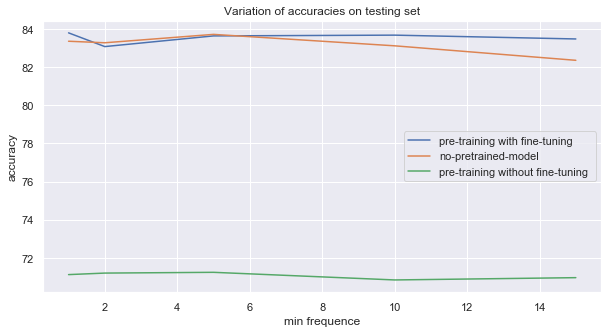

In [ ]:

sns.set(rc={'figure.figsize':(10, 5)})
fig, ax1 = plt.subplots(ncols=1, sharey=True)
ax1.set_xlabel("min frequence")
ax1.set_ylabel("accuracy")
sns.lineplot(x=df["min frequence"], y=df.acc_test_pt_fn_dic, label="pre-training with fine-tuning",ax=ax1)
sns.lineplot(x=df["min frequence"], y=df.acc_test_no_pt_dic, label="no-pretrained-model",ax=ax1)
sns.lineplot(x=df["min frequence"], y=df.acc_test_pt_no_fn_dic, label="pre-training without fine-tuning ",ax=ax1)
ax1.legend()
ax1.set_title('Variation of accuracies on testing set')

**Comment**

We start our analysis by camparing the 3 cases on **the testing set**:
*  The **pre-training without fine-tuning** is slightly constant when the min frequence increases.
*  The **pre-training with fine-tuning** and **no-pretrained-model** are near each other until **min frequence = 5**, where accuracy start to decrease, more visual for **no-pretrained-model.**


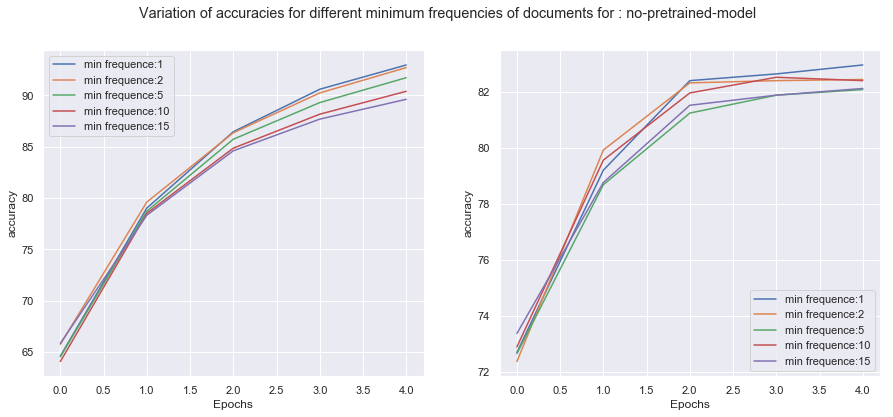

In [ ]:
plot_results_1(df.acc_tr_no_pt_dic, df.acc_val_no_pt_dic, "no-pretrained-model")

**Comment**

* In the **training phase: (on the left)** for all min frequencies values one can notice that they have the same bahevior, with changing direction at the same points. All graphs are near each other, they start getting far after the second epoch, the **min frequence = 1** takes the lead after the third epoch.
* In the **validation phase: (on the right)** same observations mentionned for the **training phase** with a slight decrease in accuracy for **min frequence = 5.**

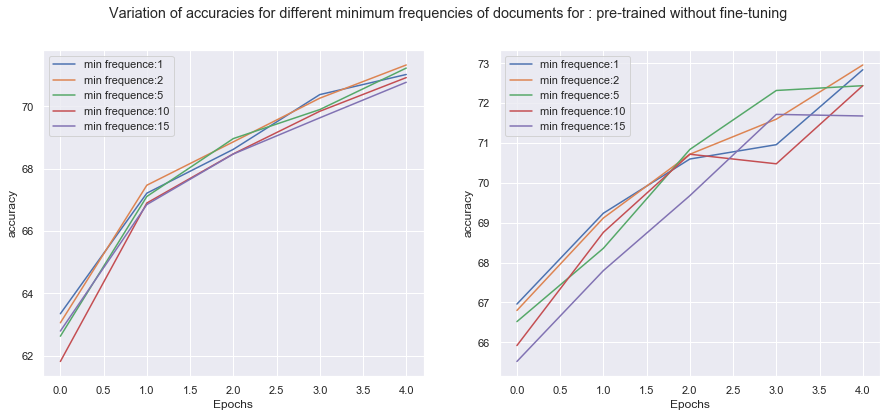

In [ ]:
plot_results_1(df.acc_tr_pt_no_fn_dic, df.acc_val_pt_no_fn_dic, "pre-trained without fine-tuning")

**Comment**

* In the **training phase: (on the left)** same observations related for **no-pretrained-model** except that the **min frequence = 2** takes the lead in terms of accuracy.
* In the **validation phase: (on the right)** the **min frequence = 2** remains the top after the third epoch, linear increase for the **min frequence = 15** until the fourth epoch.

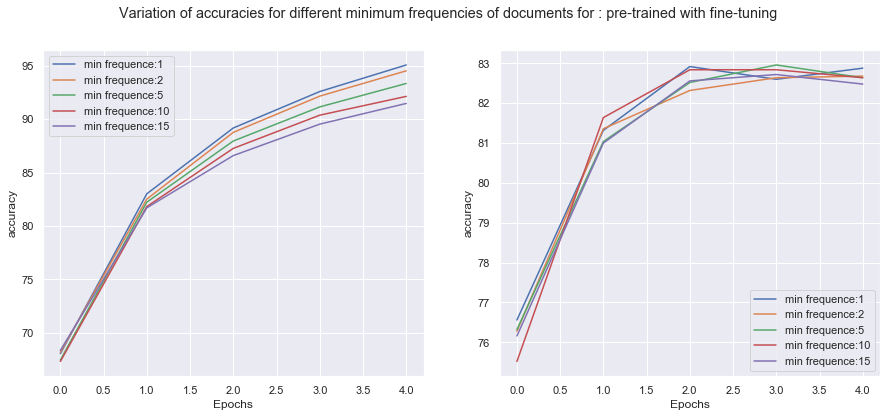

In [ ]:
plot_results_1(df.acc_tr_pt_fn_dic, df.acc_val_pt_fn_dic, "pre-trained with fine-tuning")

**Comment**

* In the **training phase: (on the left)** we observe exactly the same conclusions made for **no-pretrained-model** version.
* In the **validation phase: (on the right)** the **min frequence = 1** takes the lead after the fourth epoch, with decrease in accuracy for **min frequence = 5** and **min frequence = 10** at the same epoch.

##### 2.4 Conclusion

Our hypothesis are perfectly verified on the testing set, and at the training and validation phases for the **no-pretrained-model** and **pre-trained with fine-tuning**, the **min frequency of 1** takes always the lead after few epochs.

# Deep Learning Algorithms

## LSTM Model
We'll implement now a LSTM model, taking the same inputs and also outputing a score for the sentence.

In [37]:
from torch.autograd import Variable
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, hidden_dim=100, num_layers=2, embeddings=None, fine_tuning=False, dropout=0.5, bidirectional=True):
        # A compléter  
        super(LSTMModel, self).__init__()
        # Embeddings
        if embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings))
            if fine_tuning :
                self.embedding.weight.requires_grad = True
        elif embeddings is None: 
            self.embedding = nn.Embedding(vocabulary_size, embedding_dim, padding_idx=0)
        # LSTM 
        self.lstm = nn.LSTM(input_size = embedding_dim,
                            hidden_size = hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                           dropout=dropout,
                          bidirectional=bidirectional)
        """
        
        The LSTM takes word embeddings as inputs, and outputs hidden states with dimensionality hidden_dim.
        - input_size: the number of features for each word in the input in our model.
                   In our case, the embedding_dim = 300 for each word.
        - hidden_size: it defines the number of LSTM hidden units.
        - num_layers: the number of stacking LSTM layers in the model. (2 in our case)
        - batch_first: expects the batch dimension in the input to be first as [batch_size, sentence_length, embbeding_dim]
        - dropout: it produces a dropout probability on each output of the LSTM layer except the last one.
        - bidirectional: if True, introduces a Bi-directional LSTM 
        
        """
        self.linear_1 = nn.Linear(hidden_dim*num_layers, 1)
        self.dropout = nn.Dropout(dropout)
        self.num_layers = num_layers

    def forward(self, inputs):
        #inputs = inputs.to(device)
        embeds = self.embedding(inputs)
        lstm_out, (h_state, c_state) = self.lstm(embeds)
        # We take the last hidden state of the forward output and the last hidden state
        # of the backward output and merge them together.
        h_f_b = torch.cat((h_state[-2, :, :], h_state[-1, :, :]), dim=1)
        dropout_1 = self.dropout(h_f_b)
        out = self.linear_1(dropout_1).squeeze()
        return out

## CNN Model

In [39]:
class CNNModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, embeddings=None, window_size: int = 16, filter_multiplier = 64, fine_tuning=False, dropout=0.5, hidden_dim=None):
        super(CNNModel, self).__init__()
        # 'hidden_dim' argument has no meaning we just add to make experiments easy in comparison.
        # Embeddings
        if embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings))
            if fine_tuning :
                self.embedding.weight.requires_grad = True
        else: 
            self.embedding = nn.Embedding(vocabulary_size + 1, embedding_dim)
        # CNN
        self.conv_1 = nn.Conv2d(in_channels=1,
                            out_channels=filter_multiplier,
                            kernel_size=(window_size,embedding_dim))
        """
          - in_channels: The number of channels the convolution operation is going to be performed on.
                        Normally for RGB image "in_channels' is 3 (number of colors). But, since we are working 
                        with text we choose 1.
          - out_channels : It consists usually of the number of filters used.
          - kernel_size: Each row in the input matrix represents a different word, so the kernel-width will have same dimension
                        as the embedding dimension to cover all the word, while the kernel-length will have the same length
                        of the sequence.
        The dimension of the output will be [batch size, number of filters, out, 1] with out = (input_n + 2*p - k)/s + 1  
        where, input_n is sentence_length, k is kernel_size, p is padding_size and s is stride_size.
                       
        """
        self.linear = nn.Linear(1*filter_multiplier, 1) # If we have a list of filters, we use len(window_size) intead of 1.
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs): 
        # inputs size: [batch size, sent_len]
        embeds = self.embedding(inputs)
        # embedded size = [batch size, sent_len, embedding_dim]
        embeds = embeds.unsqueeze(1)
        # embedded size = [batch size, 1, sent_len, embedding_dim]
        conved = self.conv_1(embeds).squeeze(3)
        #conv = [batch size, filter_multiplier, sent_len - window_size]
        pooled = Func.max_pool1d(conved, conved.shape[2]).squeeze(2)
        #pooled = [batch size, filter_multiplier]
        dropout_1 = self.dropout(pooled)
        out = self.linear(dropout_1).squeeze()
        return out

## Questions:

- What do you see with a simple application of LSTMs and CNNs models ? 
- Similarly, make hypothesis based on your intuition and the class on how
    - the number of documents 
    - the size of the vocabulary 
  will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning) for the LSTM **or** CNN (and the CNN should be quite faster !) and verify your hypothesis with experiments and analyze your results !
- Present your results in a clear and synthetic way (table, figures) and be careful to experimental methodology. Notably, you should fix hyperparameters before making comparisons (you should use maximum length of sentences and batch sizes to accelerate training - similarly, using a SGD optimizer will be faster than Adam) ! 

### Question 1:
A simple application of LSTM and CNN models without pretrained embedding and fine tunning

In [45]:
splits = (0.8, 0.1)
(train_f, train_c), (valid_f, valid_c), (test_f, test_c) = get_splits(filenames, categories, splits, portion = 1)
training_dataset = TextClassificationDataset(train_f, train_c)
training_word2idx, training_idx2word = training_dataset.get_vocab()
valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)
voc_size = len(training_word2idx)
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [47]:
embedding_dim = 300
voc_size = len(training_word2idx)
hidden_dim = 512
lstm_model  = LSTMModel(embedding_dim, voc_size, hidden_dim=hidden_dim, dropout = 0.25)
lstm_model.to(device)
# Number of parameters to be trained in LSTM model:
lstm_para = sum([param.nelement() for param in lstm_model.parameters()])
print('Number of parameters to be trained in LSTM model;',lstm_para)
# Create an optimizer
opt = optim.Adam(lstm_model.parameters(),lr=1e-3, betas=(0.9, 0.999))
# The criterion is a binary cross entropy loss based on logits - meaning that the sigmoid is integrated into the criterion
criterion = nn.BCEWithLogitsLoss()
start_time = time.time()
train_losses, train_epoch_losses, val_epoch_losses, train_epoch_accs, val_epoch_accs = experiment(lstm_model, opt, criterion, training_dataloader, valid_dataloader, early_stopping=False, GPU=True)
print('Test accuracy:', eval_model(lstm_model,criterion, test_dataloader, GPU = True)[1])
print("--- %s seconds ---" % (time.time() - start_time))

Number of parameters to be trained in LSTM model; 18154817
Beginning training...
Epoch 1 : Training loss = 0.6569014537334442; Training acc = 60.51
_______  Validation loss = 0.6412891042232514; Validation acc = 63.72
Epoch 2 : Training loss = 0.594269340634346; Training acc = 68.615
_______  Validation loss = 0.6038312497735023; Validation acc = 67.72
Epoch 3 : Training loss = 0.508446187376976; Training acc = 75.46
_______  Validation loss = 0.5481399384140968; Validation acc = 73.84
Epoch 4 : Training loss = 0.4408439549803734; Training acc = 79.845
_______  Validation loss = 0.48043347969651223; Validation acc = 78.04
Epoch 5 : Training loss = 0.3089608897268772; Training acc = 86.965
_______  Validation loss = 0.46061808601021764; Validation acc = 80.16
Test accuracy: 79.44
--- 208.1876769065857 seconds ---


In [ ]:
cnn_model  = CNNModel(embedding_dim, voc_size, dropout=0.5)
cnn_model.to(device)
cnn_para = sum([param.nelement() for param in cnn_model.parameters()])
print('Number of parameters to be trained in CNN model:', cnn_para)
opt = optim.Adam(cnn_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()
start_time = time.time()
train_losses, train_epoch_losses, val_epoch_losses, train_epoch_accs, val_epoch_accs = experiment(cnn_model, opt, criterion, training_dataloader, valid_dataloader, early_stopping=False, GPU=True)
print('Test accuracy:', eval_model(cnn_model,criterion, test_dataloader, GPU = True)[1])
print("--- %s seconds ---" % (time.time() - start_time))

Number of parameters to be trained in CNN model: 8774829
Beginning training...
Epoch 1 : Training loss = 0.7098411071300507; Training acc = 57.55
_______  Validation loss = 0.6040852272510528; Validation acc = 68.6
Epoch 2 : Training loss = 0.5484908357262611; Training acc = 72.02
_______  Validation loss = 0.5593674555420876; Validation acc = 70.0
Epoch 3 : Training loss = 0.4250684228539467; Training acc = 81.06
_______  Validation loss = 0.5313488417863845; Validation acc = 73.8
Epoch 4 : Training loss = 0.2988714587688446; Training acc = 88.24
_______  Validation loss = 0.5400943931937218; Validation acc = 73.44
Epoch 5 : Training loss = 0.19024552389979363; Training acc = 93.41
_______  Validation loss = 0.5599392430484295; Validation acc = 74.6
Test accuracy: 74.68
--- 12.785850763320923 seconds ---


**Comment**
* We can observe that LSTM model perfoms better than CNN in terms of accuracy (78.88% vs 74.68% in test). But CNN is fast than LSTM which is obvious since LSTM introduces more trainebale parameters.
* CNN model have more tendency to overfit then LSTM even if we use dropout. To reduce this effect, we can either use early stopping or choose a low learning rate and use more epochs.
* Since we get an accuracy close to 80% in our classification task, we can say that the trained embedding generated during the modeling stage is very representative and can be used as input for other task that involve IMDB data.

### Question 2:

#### Hypotheses

**GloVe** is an unsupervised learning algorithm for words representations where the training is performed on aggregated global word-word co-occurrence statistics from a corpus. The pretrained model "glove-wiki-gigaword-300" used is trained on a wikipidea data which is different from  IMDB one. Furthermore complex models trained on a small dataset are more likely to see patterns that do not exist which lead to overfitting. Based on that, we assume that:
* The no-pretrained model and pretrained one will be close in results
* More the number of documents is higher more the accuracy of the three versions of the model will be better.
* Using the pretrained embeddings with fine tuning while training the model will make it outperforming other versions because the embedding is not randomly intialiazed and will improve the result by increasing the number of documents.
* Increasing too much the value of the minimum frequency for the tokens to be included will affect negatively the performance of the models.

To verify these hypotheses we will produce the following experiements: 

* **Experiment 1:** We fix the min_freq to 5, then we change the number of documents by taking each time a portion in : [0.2, 0.4, 0.6, 0.8, 1].
* **Experiment 2:** We take al documents, then we change the value of the min_freq : [1, 2, 5, 10, 15]. 

**Notes**: We tested the SGD algorithm to optimize our cost function but the results were not good as Adam optimizer. So, we will keep the same optimizer used before. The hyper parameters used for LSTM and CNN models are not the best ones we just initialse them to do our experiments. So, we expect that the three versions of the model using CNN or LSTM will potentially overfitt.  
We define each version of the model by:
- **version 1**: without pretrained embedding;
- **version 2**: with pretrained embedding but without fine tuning;
- **version 3**: with pretrained embedding and fine tuning;


#### Number of documents

##### 1.1 Experiments: LSTM
The impact of number of documents on LSTM models performance.

In [42]:
# This function help us to produce all experiments by just changing teh name of the test:
def compare(model, embedding_dim, hid_n, dropout, GPU, portions, splits, tests='portion'):
    acc_tr_no_pt_dic = {}
    acc_val_no_pt_dic = {}
    acc_tr_pt_no_fn_dic = {}
    acc_val_pt_no_fn_dic = {}
    acc_tr_pt_fn_dic = {} 
    acc_val_pt_fn_dic = {}
    acc_test_no_pt_dic = {}
    acc_test_pt_no_fn_dic  = {}
    acc_test_pt_fn_dic = {}

    for p in portions:
        if tests=='min_freq':
            pr = 1
            min_freq = p
        elif tests=='portion':
            pr = p
            min_freq = 5
        print("-----Generating Data for "+str(tests)+": "+str(p)+"-----")
        (train_f, train_c), (valid_f, valid_c), (test_f, test_c) = get_splits(filenames, categories, splits, portion = pr)
        training_dataset = TextClassificationDataset(train_f, train_c,min_freq = min_freq)
        training_word2idx, training_idx2word = training_dataset.get_vocab()
        valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word), min_freq = min_freq)
        test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word), min_freq = min_freq)
        training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
        test_dataloader = DataLoader(test_dataset, batch_size = 25)
        voc_size = len(training_word2idx)
        GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

        # No pre-training model
        print("No pre-training model...")
        my_model = model(embedding_dim, voc_size, hidden_dim=hid_n, dropout = dropout)
        my_model = my_model.to(device)
        opt = optim.Adam(my_model.parameters(),lr=0.0025, betas=(0.9, 0.999))
        criterion = nn.BCEWithLogitsLoss()
        _, loss_tr_no_pt, loss_val_no_pt, acc_tr_no_pt, acc_val_no_pt = experiment(my_model, opt, criterion, training_dataloader, valid_dataloader, early_stopping=False, GPU=GPU)
        _, test_acc = eval_model(my_model, criterion, test_dataloader, GPU=GPU)
        print('test_acc:', test_acc)
        acc_tr_no_pt_dic[p] = acc_tr_no_pt
        acc_val_no_pt_dic[p] = acc_val_no_pt
        acc_test_no_pt_dic[p] = test_acc
        del my_model

        # pre-training without fine-tuning
        print("Pre-training without fine-tuning...")
        my_model = model(embedding_dim, voc_size, hidden_dim=hid_n, embeddings=GloveEmbeddings, dropout = dropout)
        my_model = my_model.to(device)
        opt = optim.Adam(my_model.parameters(),lr=0.0025, betas=(0.9, 0.999))
        _, loss_tr_pt_no_fn, loss_val_pt_no_fn, acc_tr_pt_no_fn, acc_val_pt_no_fn = experiment(my_model, opt, criterion, training_dataloader, valid_dataloader, early_stopping=False, GPU=GPU)
        _, test_acc = eval_model(my_model, criterion, test_dataloader, GPU=GPU)
        print('test_acc:', test_acc)
        acc_tr_pt_no_fn_dic[p] = acc_tr_pt_no_fn
        acc_val_pt_no_fn_dic[p] = acc_val_pt_no_fn
        acc_test_pt_no_fn_dic[p] = test_acc
        del my_model

        # pre-training with fine-tuning
        print("Pre-training with fine-tuning...")
        my_model = model(embedding_dim, voc_size, hidden_dim=hid_n, embeddings=GloveEmbeddings, fine_tuning=True, dropout = dropout)
        my_model = my_model.to(device)
        opt = optim.Adam(my_model.parameters(),lr=0.0025, betas=(0.9, 0.999))
        _, loss_tr_pt_fn, loss_val_pt_fn, acc_tr_pt_fn, acc_val_pt_fn = experiment(my_model, opt, criterion, training_dataloader, valid_dataloader, early_stopping=False, GPU=GPU)
        _, test_acc = eval_model(my_model, criterion, test_dataloader, GPU=GPU)
        print('test_acc:', test_acc)
        acc_tr_pt_fn_dic[p] = acc_tr_pt_fn
        acc_val_pt_fn_dic[p] = acc_val_pt_fn
        acc_test_pt_fn_dic[p] = test_acc
        del my_model
    return acc_tr_no_pt_dic, acc_val_no_pt_dic, acc_tr_pt_no_fn_dic, acc_val_pt_no_fn_dic, acc_tr_pt_fn_dic, acc_val_pt_fn_dic, acc_test_no_pt_dic, acc_test_pt_no_fn_dic, acc_test_pt_fn_dic

In [114]:
training_model = False
if training_model:
    hid_n = 512
    GPU = True
    dropout = 0.0
    portions = [0.2, 0.4, 0.6, 0.8, 1]
    A, B, C, D, E, F, G, H, I = compare(LSTMModel, embedding_dim, hid_n, dropout, GPU, portions, splits, tests='portion')
    acc_tr_no_pt_dic, acc_val_no_pt_dic = A, B
    acc_tr_pt_no_fn_dic, acc_val_pt_no_fn_dic = C, D,
    acc_tr_pt_fn_dic, acc_val_pt_fn_dic = E, F
    acc_test_no_pt_dic, acc_test_pt_no_fn_dic, acc_test_pt_fn_dic = G, H, I

    table_lstm = pd.DataFrame(list(zip(acc_tr_no_pt_dic.keys(), acc_tr_no_pt_dic.values(), acc_val_no_pt_dic.values(),
                                acc_tr_pt_no_fn_dic.values(), acc_val_pt_no_fn_dic.values(), acc_tr_pt_fn_dic.values(),
                                acc_val_pt_fn_dic.values(), acc_test_no_pt_dic.values(), acc_test_pt_no_fn_dic.values(),
                                acc_test_pt_fn_dic.values())),
                    columns =['portion','acc_tr_no_pt_dic', 'acc_val_no_pt_dic', 'acc_tr_pt_no_fn_dic',
                              'acc_val_pt_no_fn_dic', 'acc_tr_pt_fn_dic', 'acc_val_pt_fn_dic', 'acc_test_no_pt_dic',
                              'acc_test_pt_no_fn_dic', 'acc_test_pt_fn_dic'])
    table_lstm.to_csv('./Results/table_lstm.csv')
else: 
    table_lstm = pd.read_csv('./Results/table_lstm.csv').drop(columns = ['Unnamed: 0'])

table_lstm

,portion,acc_tr_no_pt_dic,acc_val_no_pt_dic,acc_tr_pt_no_fn_dic,acc_val_pt_no_fn_dic,acc_tr_pt_fn_dic,acc_val_pt_fn_dic,acc_test_no_pt_dic,acc_test_pt_no_fn_dic,acc_test_pt_fn_dic
0,0.2,"[53.4, 66.725, 79.425, 91.375, 97.15]","[55.0, 59.4, 64.6, 60.8, 60.6]","[52.95, 58.225, 62.5, 58.65, 62.35]","[57.8, 56.0, 55.0, 61.4, 68.8]","[54.55, 55.45, 66.5, 79.1, 89.95]","[62.0, 60.0, 68.6, 70.0, 73.0]",61.000000,63.000000,67.200000
1,0.4,"[55.7875, 69.3625, 79.35, 90.4125, 96.95]","[61.6, 70.6, 70.0, 72.0, 73.3]","[56.95, 59.975, 65.9375, 74.9125, 78.1875]","[52.5, 60.7, 68.9, 77.3, 78.0]","[54.0125, 68.0125, 83.6, 90.1, 96.825]","[57.3, 74.7, 77.5, 77.9, 76.9]",73.600000,79.100000,75.400000
2,0.6,"[53.18333333333333, 58.775, 73.66666666666667,...","[57.2, 62.666666666666664, 74.33333333333333, ...","[58.233333333333334, 54.45, 59.40833333333333,...","[63.06666666666667, 49.6, 58.4, 58.86666666666...","[55.075, 67.90833333333333, 84.49166666666666,...","[55.266666666666666, 74.2, 79.26666666666667, ...",77.866667,69.666667,80.333333
3,0.8,"[52.76875, 55.83125, 65.94375, 77.8625, 87.3625]","[53.7, 57.75, 64.85, 73.55, 74.25]","[56.91875, 69.5375, 78.71875, 80.7875, 82.50625]","[68.3, 77.85, 80.5, 80.4, 80.3]","[60.425, 79.63125, 89.74375, 95.425, 97.89375]","[60.8, 80.85, 82.95, 80.4, 79.75]",71.950000,79.750000,79.450000
4,1.0,"[61.62, 73.795, 84.73, 91.255, 94.915]","[70.4, 74.44, 80.0, 80.72, 81.32]","[59.865, 66.425, 76.485, 80.305, 82.46]","[71.44, 65.04, 78.24, 80.68, 81.2]","[61.205, 77.855, 90.94, 96.12, 98.62]","[60.32, 81.28, 82.52, 81.04, 81.52]",80.800000,81.000000,81.600000


##### 1.2 Results and Analysis: LSTM

The accuracy evolution of the three versions of the LSTM model with the regard to the number of documents

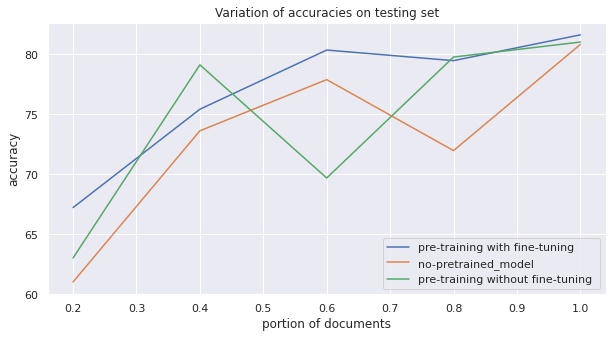

In [80]:
test_accuracy(table_lstm, "portion of documents", 'portion')

**Comment**

The figure above shows that the accuracy of the models increases proportionately with the number of documents in most of the cases but, with different speeds. In particular, training the LSTM model with the embeddings generated by GLOVE then fine tune it to our classification task, gives the best results.

Let's check each version of the LSTM model in detail

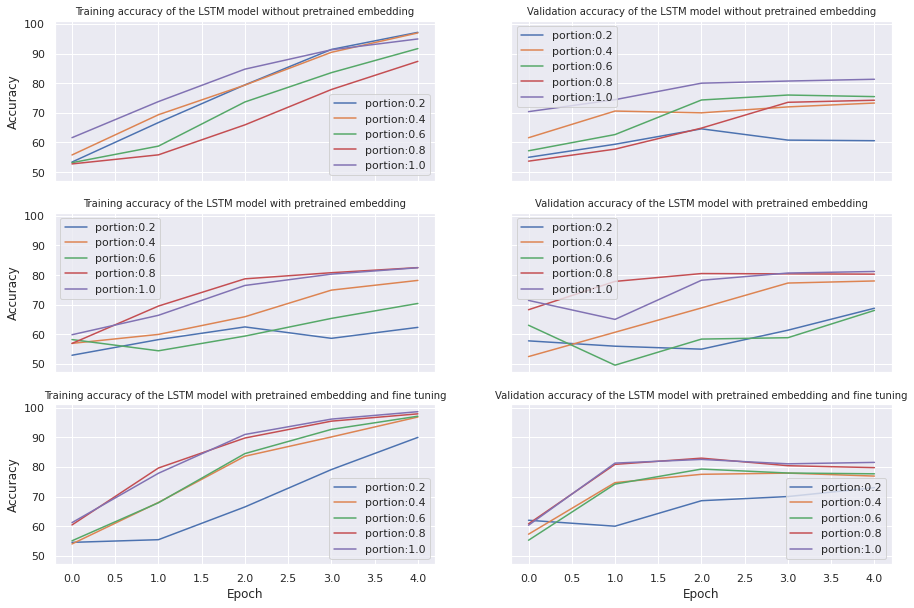

In [74]:
plot_results_2(table_lstm, 'LSTM', 'portion', portions)

**Comment**  

In the **version 2** and **version 3** of the model, we can observe that the accuracy speed is propotion to the number of documents in the training stage which is not the case for the **version 1**. However, in the validation stage, the results are more significant. 

##### 1.3 Experiments: CNN

The impact of number of document on CNN models performance.

In [115]:
training_model = False
if training_model:
    hid_n = None
    dropout = 0.5
    GPU = True
    portions = [0.2, 0.4, 0.6, 0.8, 1]
    A, B, C, D, E, F, G, H, I = compare(CNNModel, embedding_dim, hid_n, dropout, GPU, portions, splits, tests='portion')
    acc_tr_no_pt_dic, acc_val_no_pt_dic = A, B
    acc_tr_pt_no_fn_dic, acc_val_pt_no_fn_dic = C, D,
    acc_tr_pt_fn_dic, acc_val_pt_fn_dic = E, F
    acc_test_no_pt_dic, acc_test_pt_no_fn_dic, acc_test_pt_fn_dic = G, H, I
    table_cnn = pd.DataFrame(list(zip(acc_tr_no_pt_dic.keys(), acc_tr_no_pt_dic.values(), acc_val_no_pt_dic.values(),
                            acc_tr_pt_no_fn_dic.values(), acc_val_pt_no_fn_dic.values(), acc_tr_pt_fn_dic.values(),
                            acc_val_pt_fn_dic.values(), acc_test_no_pt_dic.values(), acc_test_pt_no_fn_dic.values(),
                            acc_test_pt_fn_dic.values())),
                columns =['portion','acc_tr_no_pt_dic', 'acc_val_no_pt_dic', 'acc_tr_pt_no_fn_dic',
                          'acc_val_pt_no_fn_dic', 'acc_tr_pt_fn_dic', 'acc_val_pt_fn_dic', 'acc_test_no_pt_dic',
                          'acc_test_pt_no_fn_dic', 'acc_test_pt_fn_dic'])

    table_cnn.to_csv('./Results/table_cnn.csv')
else: 
    table_cnn = pd.read_csv('./Results/table_cnn.csv').drop(columns = ['Unnamed: 0'])

table_cnn

,portion,acc_tr_no_pt_dic,acc_val_no_pt_dic,acc_tr_pt_no_fn_dic,acc_val_pt_no_fn_dic,acc_tr_pt_fn_dic,acc_val_pt_fn_dic,acc_test_no_pt_dic,acc_test_pt_no_fn_dic,acc_test_pt_fn_dic
0,0.2,"[51.5, 68.15, 83.175, 93.25, 97.2]","[54.2, 64.8, 64.8, 65.8, 67.6]","[55.975, 69.6, 79.125, 83.875, 89.375]","[53.4, 62.8, 74.0, 72.4, 74.2]","[56.775, 75.425, 87.075, 94.325, 98.475]","[67.4, 76.2, 76.8, 77.6, 77.8]",66.4,72.00,75.6
1,0.4,"[54.1375, 72.4, 84.6375, 92.625, 96.7625]","[66.5, 70.5, 70.9, 73.2, 74.3]","[61.1625, 74.625, 80.45, 84.8375, 90.0375]","[70.1, 76.3, 75.1, 77.7, 76.9]","[60.6375, 80.3375, 89.7, 96.275, 98.975]","[75.0, 77.8, 79.4, 79.4, 80.1]",71.9,78.20,81.6
2,0.6,"[57.291666666666664, 74.24166666666666, 85.508...","[65.06666666666666, 70.06666666666666, 70.6, 7...","[63.958333333333336, 76.16666666666667, 79.958...","[74.53333333333333, 75.86666666666666, 76.0666...","[64.99166666666666, 82.85833333333333, 91.825,...","[76.0, 79.53333333333333, 80.4, 77.93333333333...",73.4,74.40,80.6
3,0.8,"[57.4375, 74.68125, 84.725, 92.14375, 95.5375]","[68.6, 73.55, 74.8, 75.55, 76.65]","[65.93125, 76.2375, 80.81875, 83.7625, 87.3]","[76.45, 77.75, 78.0, 78.45, 75.2]","[69.56875, 85.14375, 93.2125, 97.675, 99.34375]","[78.95, 82.25, 81.35, 81.8, 82.1]",75.9,75.00,80.9
4,1.0,"[59.01, 75.705, 85.775, 92.44, 96.175]","[66.4, 74.56, 75.72, 76.0, 76.84]","[67.635, 77.59, 80.385, 83.99, 87.115]","[75.96, 77.36, 77.52, 77.84, 78.0]","[69.915, 85.69, 93.03, 97.23, 99.115]","[80.48, 81.76, 80.16, 81.16, 81.24]",77.0,76.76,79.6


##### 1.4 Results and Analysis: CNN

The accuracy evolution of the three versions of the CNN model with the regard to the number of documents

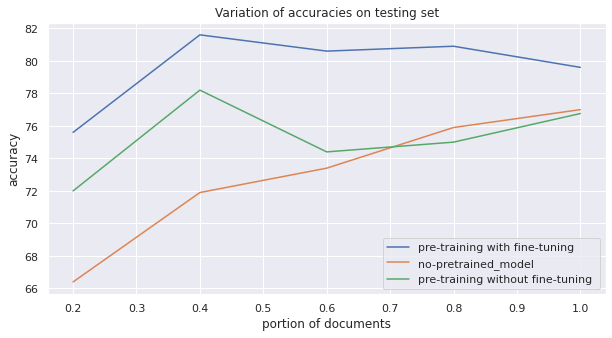

In [58]:
test_accuracy(table_cnn, "portion of documents", "portion")

**Comment**

We note that more the data is large more we get accurate results. However, using pretrained embeddings without fine tuning makes the model has a tendancy to decrease in terms of accuracy. Which means that by increasing the number of documents, the pretrained embeddings will not be representaing the words of the corpus in a consitent way anymore, especially that GLOVE embedding was built on a wikipidea corpus and not a IMDB data.

Let's check each version of the CNN model in detail

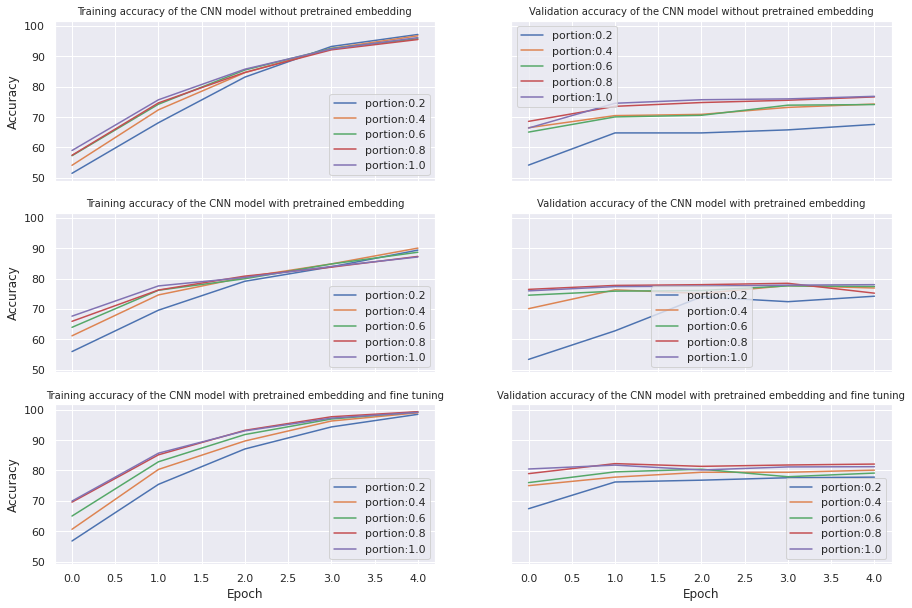

In [59]:
plot_results_2(table_cnn, 'CNN', 'portion',portions)

**Comment**

All the model versions overfit after the epoch 4 whatever the number of documents. They converge to the same value. This can be reduced by using early stopping method so, we can stop almost at epoch 3.

#### Minimum frequency

##### 2.1 Experiments: LSTM

The impact of vocabulary size on LSTM models performance

In [116]:
training_model = False
if training_model:
    dropout = 0.25
    min_freq = [1, 2, 5, 10, 15]
    A, B, C, D, E, F, G, H, I = compare(LSTMModel, embedding_dim, hid_n, dropout, GPU, min_freq, splits, tests='min_freq')
    acc_tr_no_pt_dic, acc_val_no_pt_dic = A, B
    acc_tr_pt_no_fn_dic, acc_val_pt_no_fn_dic = C, D,
    acc_tr_pt_fn_dic, acc_val_pt_fn_dic = E, F
    acc_test_no_pt_dic, acc_test_pt_no_fn_dic, acc_test_pt_fn_dic = G, H, I
    table_lstm_freq = pd.DataFrame(list(zip(acc_tr_no_pt_dic.keys(), acc_tr_no_pt_dic.values(), acc_val_no_pt_dic.values(),
                            acc_tr_pt_no_fn_dic.values(), acc_val_pt_no_fn_dic.values(), acc_tr_pt_fn_dic.values(),
                            acc_val_pt_fn_dic.values(), acc_test_no_pt_dic.values(), acc_test_pt_no_fn_dic.values(),
                            acc_test_pt_fn_dic.values())),
                columns =['min_freq','acc_tr_no_pt_dic', 'acc_val_no_pt_dic', 'acc_tr_pt_no_fn_dic',
                          'acc_val_pt_no_fn_dic', 'acc_tr_pt_fn_dic', 'acc_val_pt_fn_dic', 'acc_test_no_pt_dic',
                          'acc_test_pt_no_fn_dic', 'acc_test_pt_fn_dic'])
    table_lstm_freq.to_csv('./Results/table_lstm_freq.csv').drop(columns = ['Unnamed: 0'])
else:
    table_lstm_freq = pd.read_csv('./Results/table_lstm_freq.csv').drop(columns = ['Unnamed: 0'])

table_lstm_freq

,min_freq,acc_tr_no_pt_dic,acc_val_no_pt_dic,acc_tr_pt_no_fn_dic,acc_val_pt_no_fn_dic,acc_tr_pt_fn_dic,acc_val_pt_fn_dic,acc_test_no_pt_dic,acc_test_pt_no_fn_dic,acc_test_pt_fn_dic
0,1,"[54.515, 69.48, 84.285, 92.355, 96.365]","[58.6, 76.04, 79.44, 80.68, 80.52]","[62.395, 73.035, 78.995, 80.64, 82.03]","[71.52, 77.32, 79.76, 79.6, 79.76]","[61.06, 64.465, 80.56, 92.24, 96.54]","[60.12, 66.96, 79.32, 81.2, 80.76]",80.64,79.68,80.08
1,2,"[59.085, 75.335, 86.325, 92.605, 96.59]","[65.56, 75.08, 80.16, 79.36, 80.68]","[61.765, 72.2, 79.315, 81.425, 84.01]","[68.64, 77.04, 77.88, 80.84, 80.52]","[57.055, 70.07, 82.25, 83.06, 92.88]","[58.12, 66.6, 73.64, 78.08, 79.76]",80.80,80.48,80.24
2,5,"[57.955, 64.925, 82.05, 90.7, 95.48]","[64.96, 72.28, 81.12, 82.32, 81.68]","[60.675, 63.78, 77.28, 80.23, 82.235]","[66.32, 76.88, 72.36, 80.64, 82.48]","[58.255, 73.5, 87.98, 94.63, 97.65]","[57.72, 79.56, 83.92, 82.16, 82.72]",79.72,81.08,80.96
3,10,"[59.085, 76.605, 87.34, 92.815, 97.155]","[64.44, 79.48, 80.12, 82.0, 81.16]","[60.575, 75.545, 80.44, 82.475, 84.585]","[67.04, 76.72, 80.28, 81.92, 81.44]","[60.185, 79.665, 90.355, 94.935, 97.825]","[72.08, 83.08, 82.92, 81.68, 81.44]",80.08,80.60,80.84
4,15,"[59.115, 74.965, 85.485, 91.275, 95.325]","[67.52, 77.8, 79.4, 79.48, 78.56]","[56.385, 59.28, 75.545, 79.7, 81.255]","[59.08, 70.44, 77.8, 78.96, 80.04]","[60.8, 75.025, 87.195, 92.555, 95.54]","[67.6, 81.0, 82.52, 81.04, 80.32]",79.48,79.80,81.12


##### 2.2 Results and Analysis: LSTM
The accuracy evolution of the three versions of the LSTM model with the regard to min freq

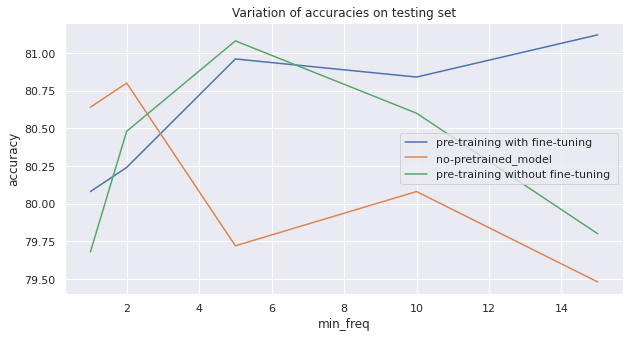

In [48]:
test_accuracy(table_lstm_freq, "min_freq", "min_freq")

**Comment**

As we expected, we can see that the accuracy decreases slicely while increasing the min_freq. This is not the case for the pretrained with fine tuning version but, we may have the same behaviour by using higher values of min_freq. Normally, if we use a high value of min_freq, the vocabulary size will decrease and the less frequent words will be dropped which might impact badly the perfomance of the models. However, finding the best min_freq is not always easy because min_freq=1 i snot the optimal one.

Let's check each version of the LSTM model in detail

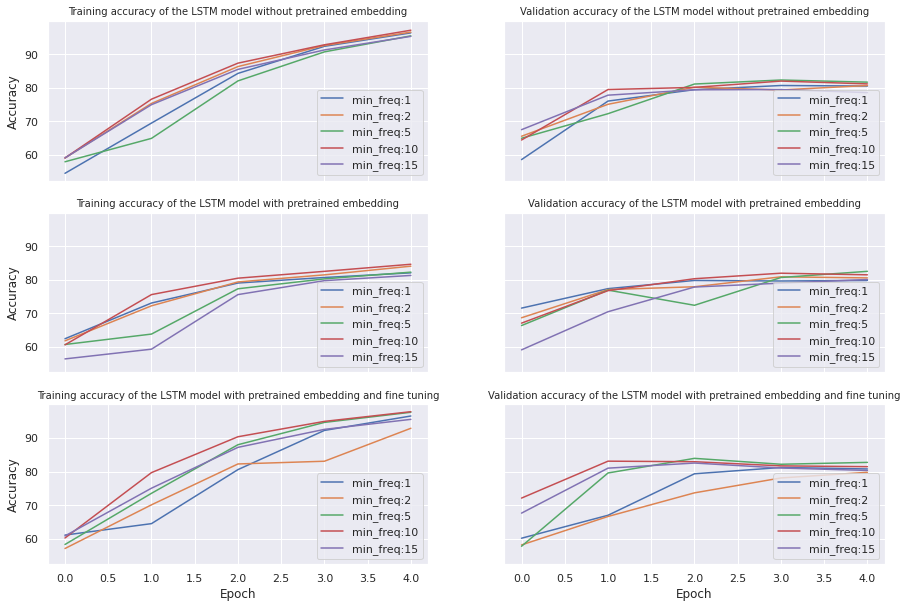

In [49]:
plot_results_2(table_lstm_freq, 'LSTM','min_freq', min_freq)

##### 2.3 Experiments: CNN

The impact of vocabulary size on CNN models performance

In [117]:
training_model = False
if training_model:
    hid_n = None
    dropout = 0.5
    A, B, C, D, E, F, G, H, I = compare(CNNModel, embedding_dim, hid_n, dropout, GPU, min_freq, splits, tests='min_freq')
    acc_tr_no_pt_dic, acc_val_no_pt_dic = A, B
    acc_tr_pt_no_fn_dic, acc_val_pt_no_fn_dic = C, D,
    acc_tr_pt_fn_dic, acc_val_pt_fn_dic = E, F
    acc_test_no_pt_dic, acc_test_pt_no_fn_dic, acc_test_pt_fn_dic = G, H, I
    table_cnn_freq = pd.DataFrame(list(zip(acc_tr_no_pt_dic.keys(), acc_tr_no_pt_dic.values(), acc_val_no_pt_dic.values(),
                           acc_tr_pt_no_fn_dic.values(), acc_val_pt_no_fn_dic.values(), acc_tr_pt_fn_dic.values(),
                           acc_val_pt_fn_dic.values(), acc_test_no_pt_dic.values(), acc_test_pt_no_fn_dic.values(),
                           acc_test_pt_fn_dic.values())),
               columns =['min_freq','acc_tr_no_pt_dic', 'acc_val_no_pt_dic', 'acc_tr_pt_no_fn_dic',
                         'acc_val_pt_no_fn_dic', 'acc_tr_pt_fn_dic', 'acc_val_pt_fn_dic', 'acc_test_no_pt_dic',
                         'acc_test_pt_no_fn_dic', 'acc_test_pt_fn_dic'])
    table_cnn_freq.to_csv('./Results/table_cnn_freq.csv')
else:
    table_cnn_freq = pd.read_csv('./Results/table_cnn_freq.csv').drop(columns = ['Unnamed: 0'])

table_cnn_freq

,min_freq,acc_tr_no_pt_dic,acc_val_no_pt_dic,acc_tr_pt_no_fn_dic,acc_val_pt_no_fn_dic,acc_tr_pt_fn_dic,acc_val_pt_fn_dic,acc_test_no_pt_dic,acc_test_pt_no_fn_dic,acc_test_pt_fn_dic
0,1,"[58.135, 74.88, 85.575, 93.035, 96.55]","[67.96, 71.36, 76.24, 77.32, 77.2]","[68.335, 77.44, 81.355, 84.56, 87.67]","[78.0, 76.92, 79.8, 78.8, 79.24]","[70.305, 86.34, 94.465, 98.365, 99.25]","[80.64, 82.52, 82.36, 82.0, 82.08]",75.40,75.60,79.72
1,2,"[58.525, 75.045, 85.255, 92.715, 96.015]","[68.04, 74.48, 76.64, 78.36, 77.28]","[68.33, 77.415, 80.97, 84.69, 87.59]","[75.32, 75.88, 75.8, 77.72, 77.6]","[71.03, 86.59, 94.435, 98.235, 99.31]","[79.68, 81.88, 81.92, 81.48, 81.0]",77.24,77.44,82.36
2,5,"[58.12, 74.435, 84.175, 91.57, 95.07]","[66.88, 72.92, 76.6, 75.52, 77.4]","[67.85, 77.315, 80.615, 83.77, 87.13]","[76.24, 78.52, 78.6, 79.68, 78.68]","[70.11, 85.39, 93.135, 97.695, 99.145]","[82.36, 83.36, 82.92, 82.72, 82.28]",77.52,78.20,82.12
3,10,"[58.71, 74.61, 84.72, 91.3, 95.175]","[69.2, 73.48, 75.04, 76.72, 77.48]","[67.61, 76.97, 81.195, 84.43, 87.175]","[76.2, 77.08, 77.92, 77.28, 77.04]","[71.215, 85.475, 92.97, 96.8, 98.755]","[80.0, 81.2, 82.08, 81.44, 81.12]",78.80,76.52,81.32
4,15,"[59.17, 74.93, 84.445, 91.185, 94.955]","[69.28, 74.72, 78.28, 77.44, 78.4]","[68.33, 77.34, 80.4, 84.155, 86.685]","[76.44, 76.92, 77.0, 78.84, 76.64]","[70.535, 84.785, 91.5, 95.97, 98.185]","[81.24, 83.12, 82.92, 82.72, 82.24]",75.48,75.72,81.48


##### 2.4 Results and Analysis: CNN

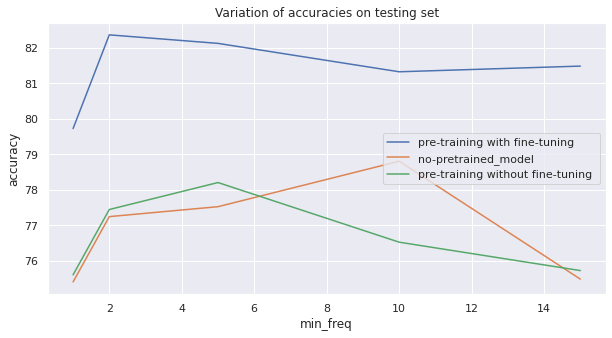

In [52]:
test_accuracy(table_cnn_freq, "min_freq", "min_freq")

**Comment**  

This figure confirms what we said before about the impact of vocabulary size on LSTM models performance.

Let's check each version of the LSTM model in detail

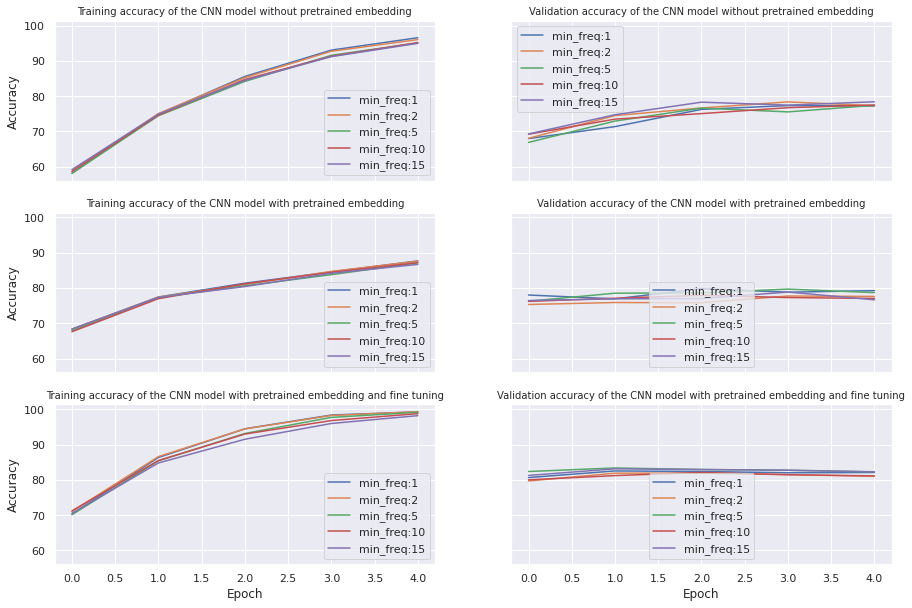

In [53]:
plot_results_2(table_cnn_freq, 'CNN', 'min_freq', min_freq)

**Comment**

Because of the plot scale, we note that all curves are stacked and have the same behaviour but this does not contradict with what we get before.

#### Conclusion

Based on the previous results, we can conlude that the number of documents impacts considerably the performance of all model versions either in CNN architecture or LSTM one. Which means that more the portion of documents is important , more the results will be accurate. In the other hand, using a high or low value of the minimum frequency is not the best choice, so we must produce many tests to find the best value that optimizes the results.  
The results we get in this Lab, cannot be generalized to all tasks since the hyperparameters of all models are not fine tuned enough. 